# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import warnings
import scipy.stats as stats
from scipy.fftpack import fft

In [2]:
from scipy.spatial.distance import euclidean
from scipy.special import erf
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
import math
import scipy.spatial

# Load stuff

In [3]:
base_path = '/Users/priyank/Desktop/ML4QS-project/Wave_right_5mins'

In [4]:
folders = [
    'Wave_right_min_1',
    'Wave_right_min_2',
    'Wave_right_min_3',
    'Wave_right_min_4',
    'Wave_right_min_5'
]

In [5]:
file_names = ['Accelerometer.csv', 'Gyroscope.csv', 'Linear Accelerometer.csv', 'Magnetometer.csv']
sensor_types = ['accelerometer', 'gyroscope', 'linear_accelerometer', 'magnetometer']

# Function to construct file paths
def construct_file_paths(base_path, folders, file_names):
    file_paths = {}
    for sensor_type, file_name in zip(sensor_types, file_names):
        file_paths[sensor_type] = [os.path.join(base_path, folder, file_name) for folder in folders]
    return file_paths

file_paths = construct_file_paths(base_path, folders, file_names)

# Function to load data files and add labels
def load_and_label_data(file_paths, label):
    dfs = []
    for file in file_paths:
        df = pd.read_csv(file)
        # Add a label column
        df['label'] = label
        dfs.append(df)
    return dfs

# Load and label data for each sensor type
label = 'waving_righthand'
data_dict = {}
for sensor_type in sensor_types:
    data_dict[sensor_type] = load_and_label_data(file_paths[sensor_type], label)

# Aggregate Data at 0.25s intervals

In [6]:
# Function to create time intervals
def create_time_intervals(start_time, end_time, delta_t):
    return np.arange(start_time, end_time, delta_t)

# Function to aggregate data within time steps
def aggregate_data(df, time_column, delta_t, numerical_columns, label):
    start_time = df[time_column].min()
    end_time = df[time_column].max()
    time_intervals = create_time_intervals(start_time, end_time, delta_t)
    
    aggregated_data = []

    for t in time_intervals:
        window = df[(df[time_column] >= t) & (df[time_column] < t + delta_t)]
        if not window.empty:
            aggregated_row = {}
            aggregated_row['time'] = t
            for col in numerical_columns:
                aggregated_row[col] = window[col].mean()
            # Add the label to the aggregated row
            aggregated_row['label'] = label
            aggregated_data.append(aggregated_row)

    return pd.DataFrame(aggregated_data)

# Define time step and columns
delta_t = 0.25  # 0.25 seconds

# Specify numerical columns for each sensor type
numerical_columns_dict = {
    'accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'gyroscope': ['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)'],
    'linear_accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'magnetometer': ['X (µT)', 'Y (µT)', 'Z (µT)']
}

# Aggregate data for each sensor type in each folder
aggregated_data_dict = {sensor_type: [] for sensor_type in sensor_types}

for sensor_type in sensor_types:
    for df in data_dict[sensor_type]:
        aggregated_df = aggregate_data(df, 'Time (s)', delta_t, numerical_columns_dict[sensor_type], label)
        aggregated_data_dict[sensor_type].append(aggregated_df)


## Save the data 

In [7]:
# Function to save aggregated data back into respective folders with modified filenames
def save_aggregated_data(base_path, folders, file_names, aggregated_data_dict, interval_label="0.25s"):
    for sensor_type, file_name in zip(sensor_types, file_names):
        for folder, df in zip(folders, aggregated_data_dict[sensor_type]):
            new_file_name = file_name.replace('.csv', f'_{interval_label}.csv')
            output_path = os.path.join(base_path, folder, new_file_name)
            df.to_csv(output_path, index=False)
            print(f"Saved aggregated data to {output_path}")

save_aggregated_data(base_path, folders, file_names, aggregated_data_dict)


Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_1/Accelerometer_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_2/Accelerometer_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_3/Accelerometer_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_4/Accelerometer_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_5/Accelerometer_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_1/Gyroscope_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_2/Gyroscope_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Wave_right_min_3/Gyroscope_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4Q

# EDA

In [8]:
file_names = ['Accelerometer_0.25s.csv', 'Gyroscope_0.25s.csv', 'Linear Accelerometer_0.25s.csv', 'Magnetometer_0.25s.csv']
sensor_types = ['accelerometer', 'gyroscope', 'linear_accelerometer', 'magnetometer']

# Function to construct file paths
def construct_file_paths(base_path, folders, file_names):
    file_paths = {}
    for sensor_type, file_name in zip(sensor_types, file_names):
        file_paths[sensor_type] = [os.path.join(base_path, folder, file_name) for folder in folders]
    return file_paths

file_paths = construct_file_paths(base_path, folders, file_names)

# Function to load aggregated data files
def load_aggregated_data(file_paths):
    dfs = {}
    for sensor_type in sensor_types:
        dfs[sensor_type] = [pd.read_csv(file) for file in file_paths[sensor_type]]
    return dfs

# Load aggregated data
aggregated_data_dict = load_aggregated_data(file_paths)

## Summary stats

In [9]:
# Display summary statistics for numerical columns
for sensor_type in sensor_types:
    print(f"Summary Statistics for {sensor_type}:")
    for df in aggregated_data_dict[sensor_type]:
        print(df.describe())


Summary Statistics for accelerometer:
             time   X (m/s^2)   Y (m/s^2)   Z (m/s^2)
count  241.000000  241.000000  241.000000  241.000000
mean    30.003407   -1.607457    2.803087    1.156925
std     17.428724   10.283331    3.340460    3.099229
min      0.003407  -23.125907   -7.132338   -8.021645
25%     15.003407  -10.136764    1.309094   -0.994077
50%     30.003407   -1.610890    3.062787    0.908084
75%     45.003407    7.454462    4.661127    3.030628
max     60.003407   19.327808    9.617231   10.534296
             time   X (m/s^2)   Y (m/s^2)   Z (m/s^2)
count  241.000000  241.000000  241.000000  241.000000
mean    29.998287   -2.135293   -2.807297    4.330389
std     17.428724   11.526991    4.481867    3.546595
min     -0.001713  -24.721535  -17.497773   -6.604865
25%     14.998287  -13.037295   -5.405056    2.296399
50%     29.998287   -1.961958   -3.130464    4.617849
75%     44.998287    8.582954   -0.798356    6.674399
max     59.998287   19.128027    9.809808   

## Missing Vals

In [10]:
# Check for missing values in the dataset
for sensor_type in sensor_types:
    print(f"Missing Values for {sensor_type}:")
    for df in aggregated_data_dict[sensor_type]:
        print(df.isnull().sum())


Missing Values for accelerometer:
time         0
X (m/s^2)    0
Y (m/s^2)    0
Z (m/s^2)    0
label        0
dtype: int64
time         0
X (m/s^2)    0
Y (m/s^2)    0
Z (m/s^2)    0
label        0
dtype: int64
time         0
X (m/s^2)    0
Y (m/s^2)    0
Z (m/s^2)    0
label        0
dtype: int64
time         0
X (m/s^2)    0
Y (m/s^2)    0
Z (m/s^2)    0
label        0
dtype: int64
time         0
X (m/s^2)    0
Y (m/s^2)    0
Z (m/s^2)    0
label        0
dtype: int64
Missing Values for gyroscope:
time         0
X (rad/s)    0
Y (rad/s)    0
Z (rad/s)    0
label        0
dtype: int64
time         0
X (rad/s)    0
Y (rad/s)    0
Z (rad/s)    0
label        0
dtype: int64
time         0
X (rad/s)    0
Y (rad/s)    0
Z (rad/s)    0
label        0
dtype: int64
time         0
X (rad/s)    0
Y (rad/s)    0
Z (rad/s)    0
label        0
dtype: int64
time         0
X (rad/s)    0
Y (rad/s)    0
Z (rad/s)    0
label        0
dtype: int64
Missing Values for linear_accelerometer:
time         0


## Correlation Matrix

Correlation Matrix for accelerometer:


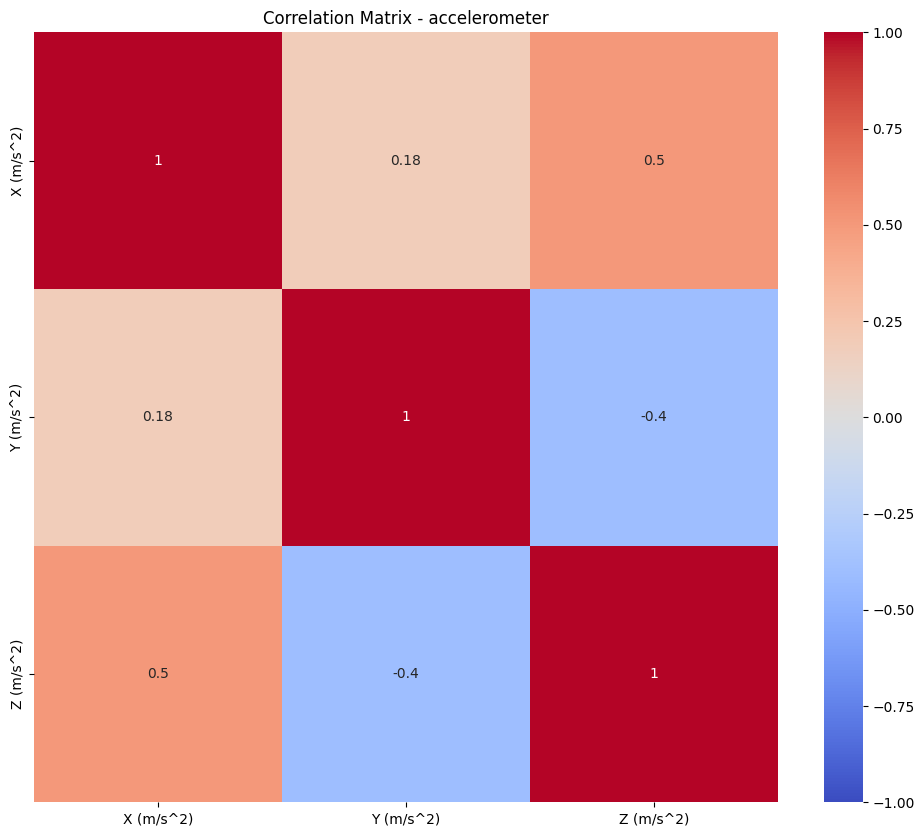

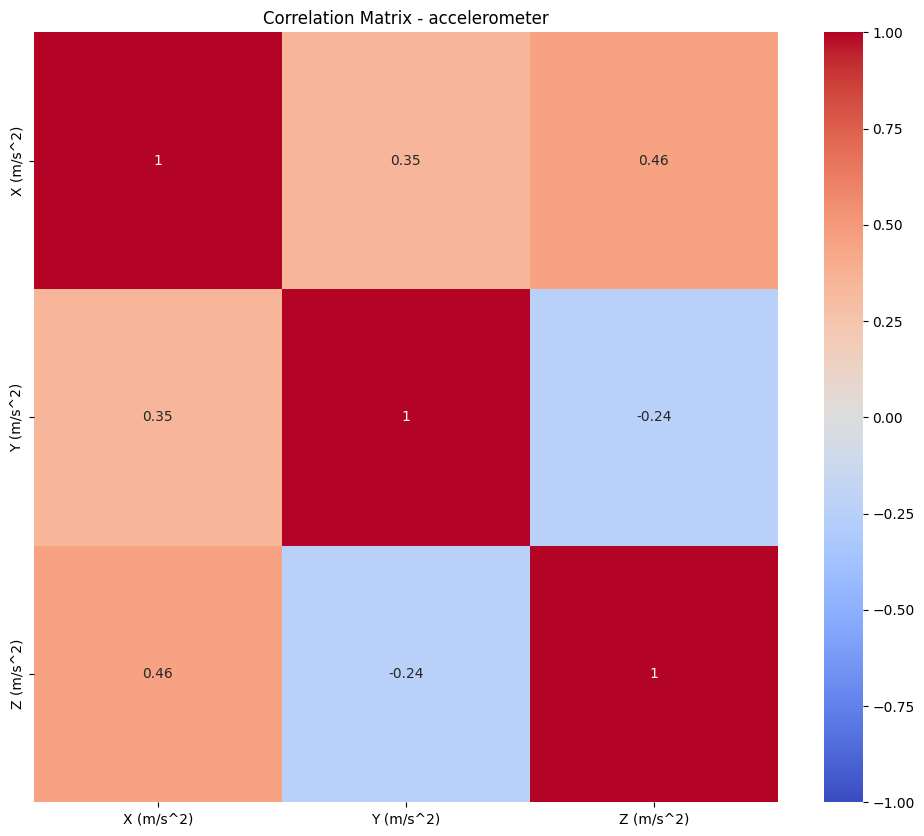

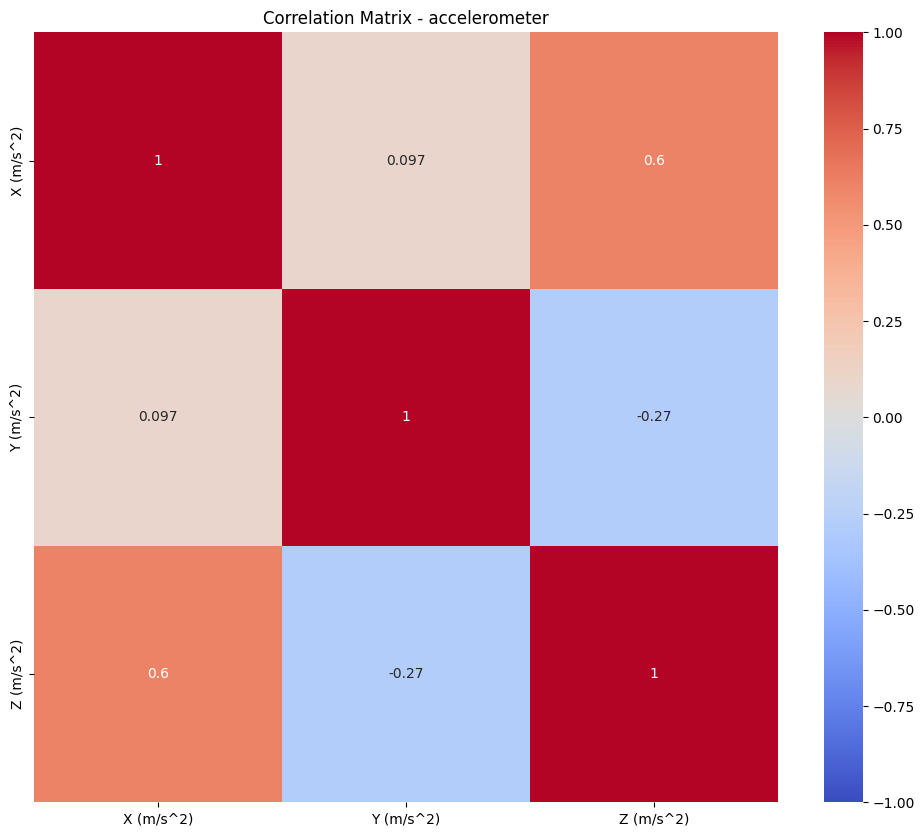

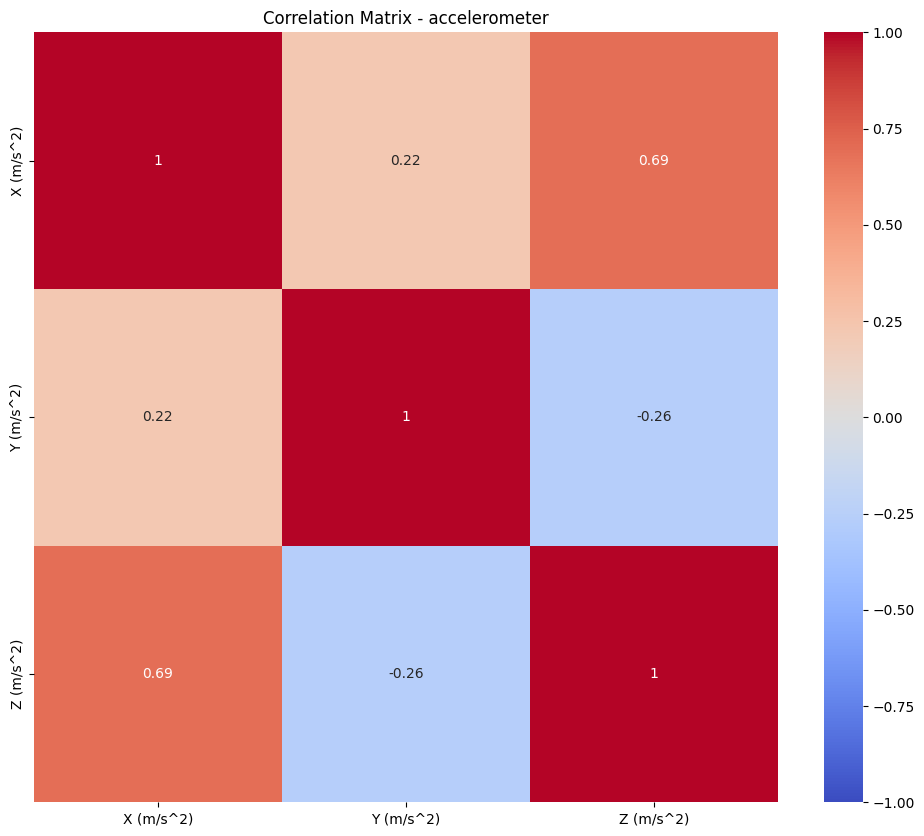

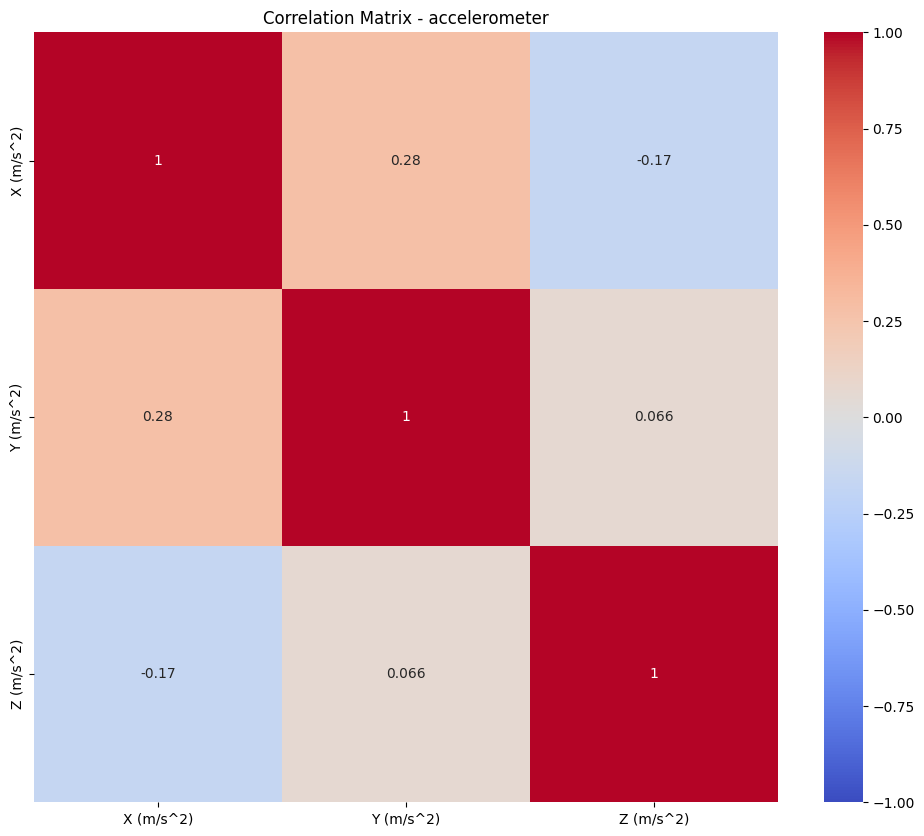

Correlation Matrix for gyroscope:


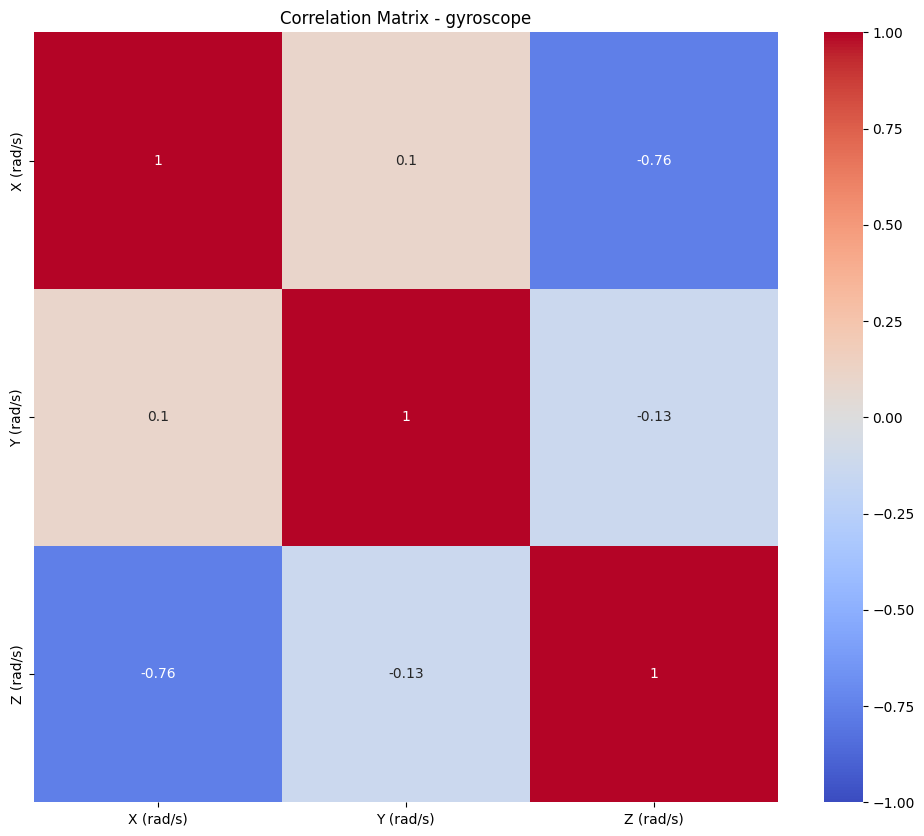

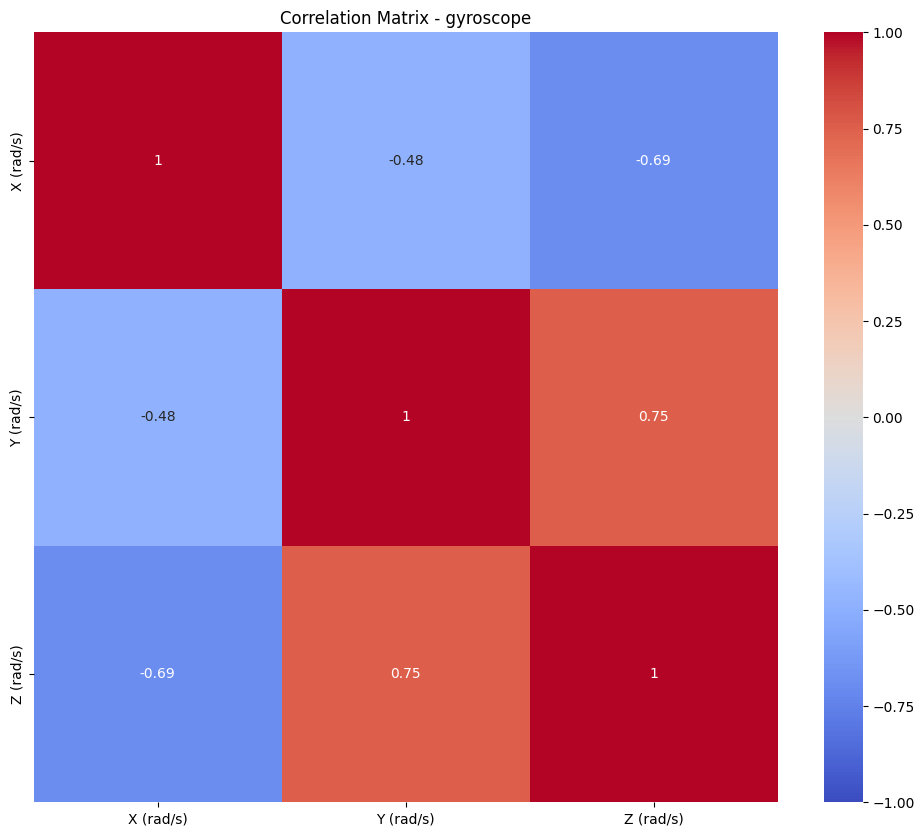

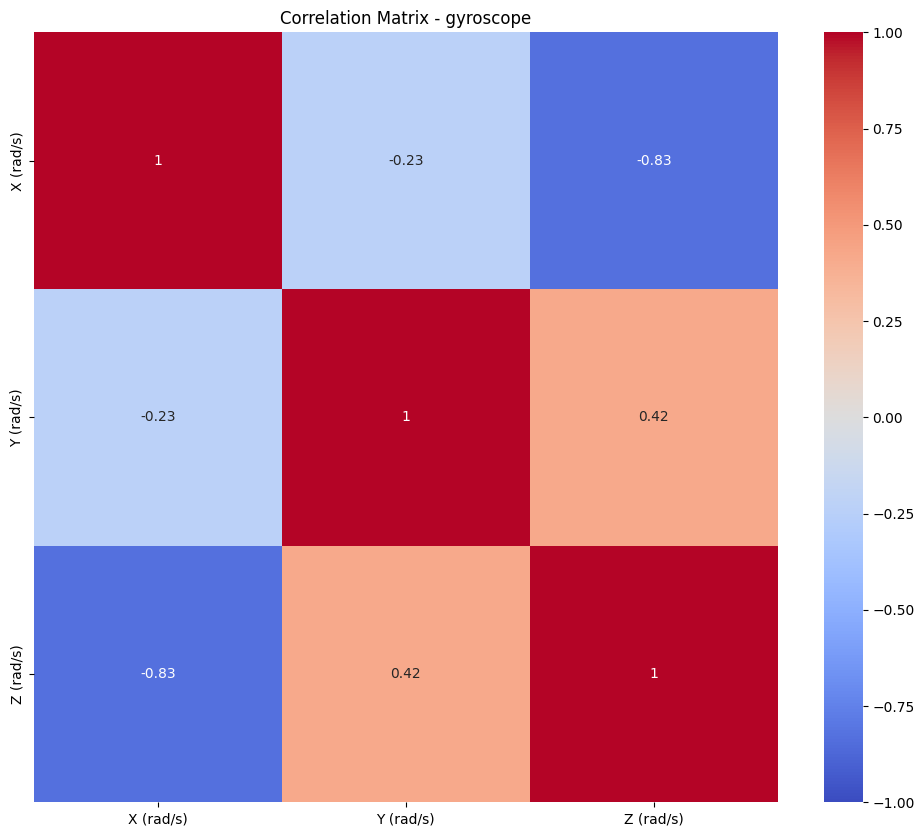

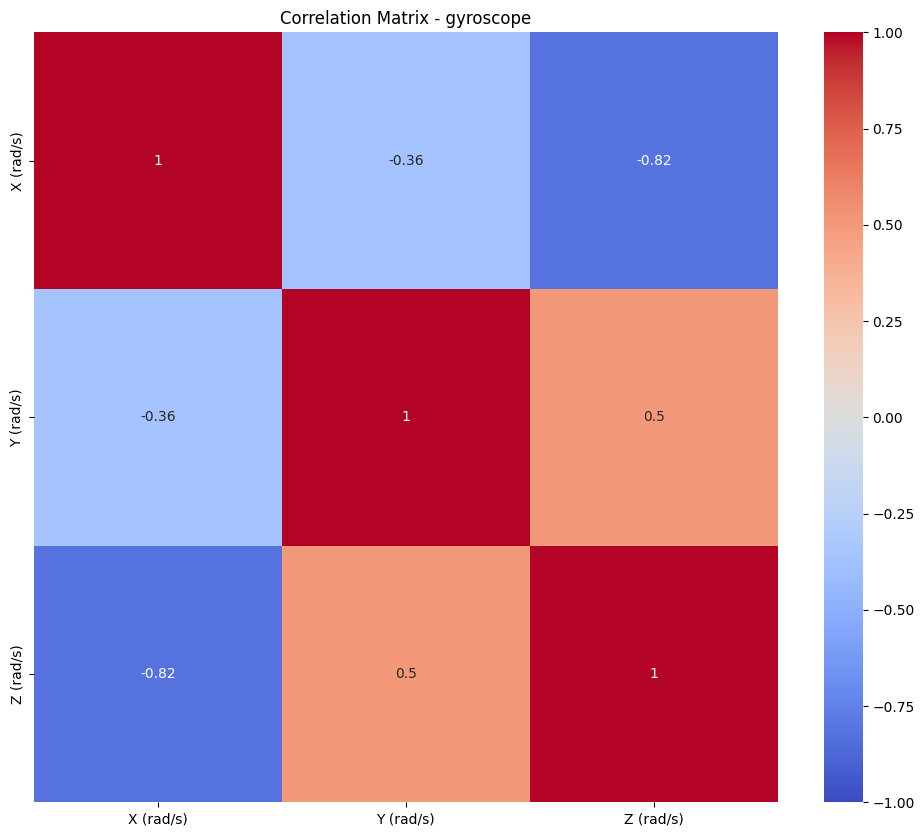

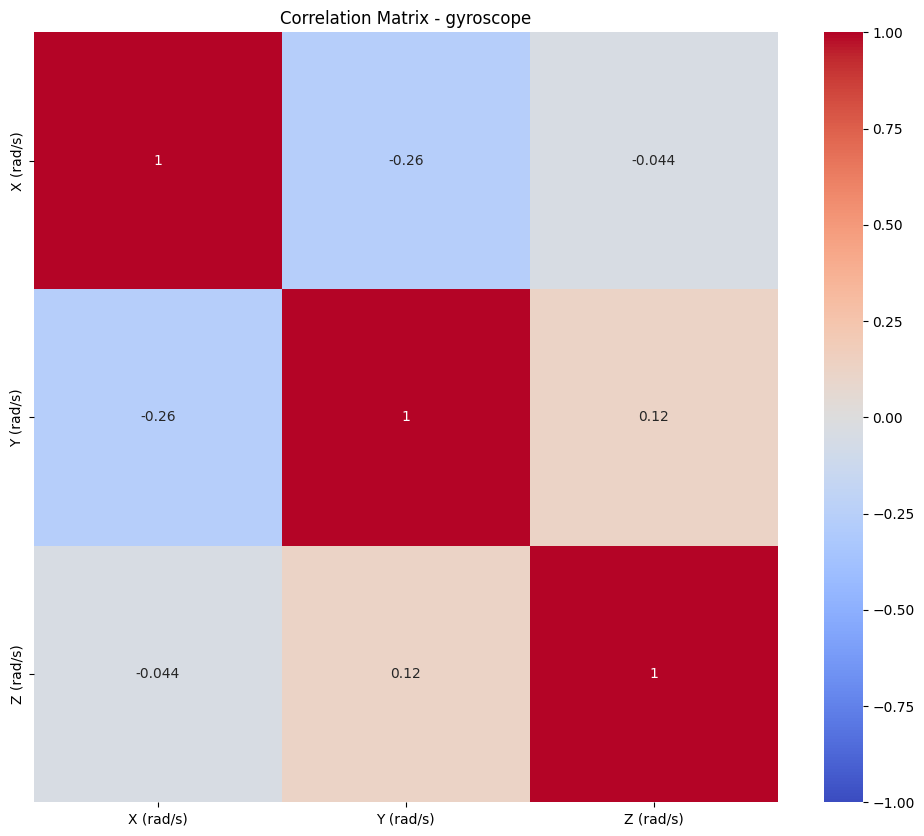

Correlation Matrix for linear_accelerometer:


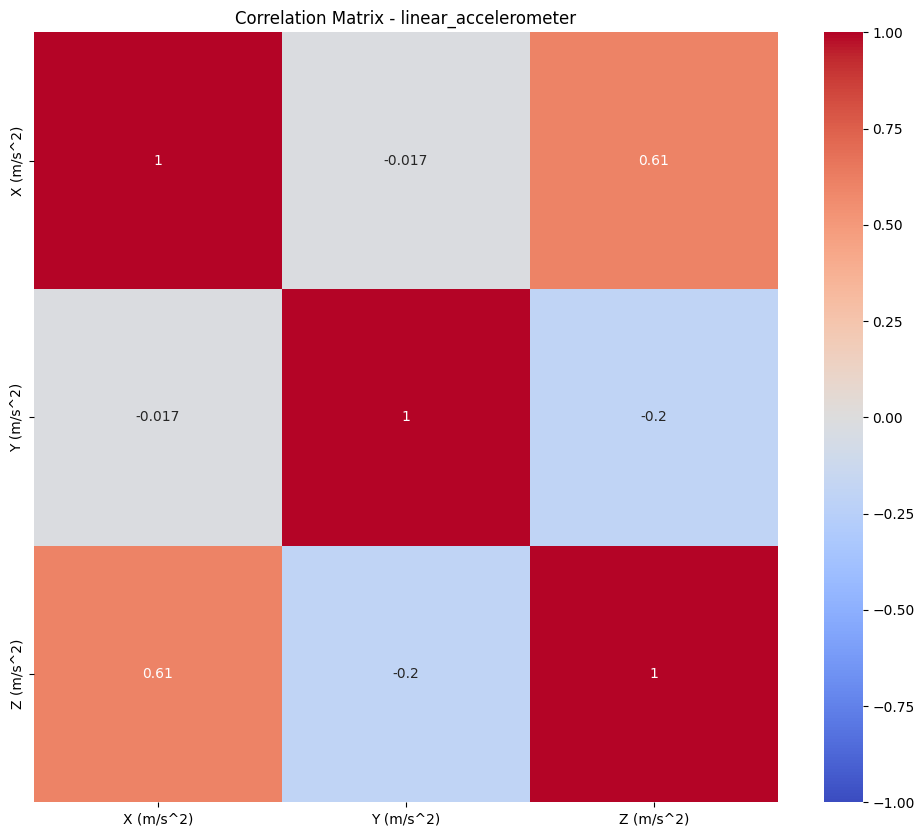

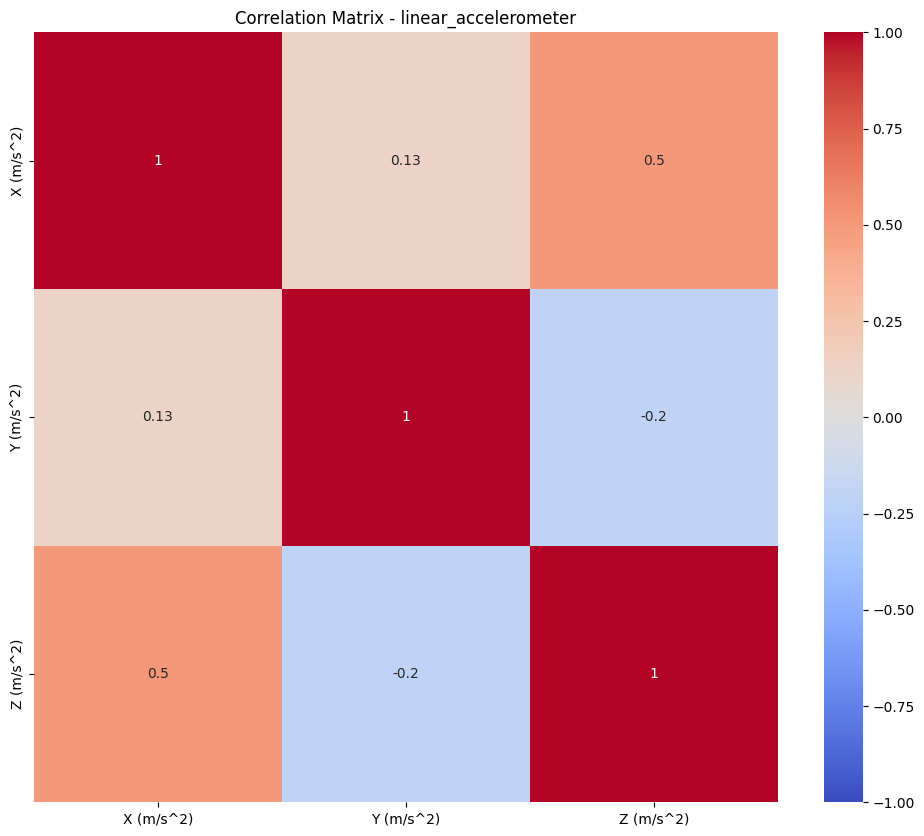

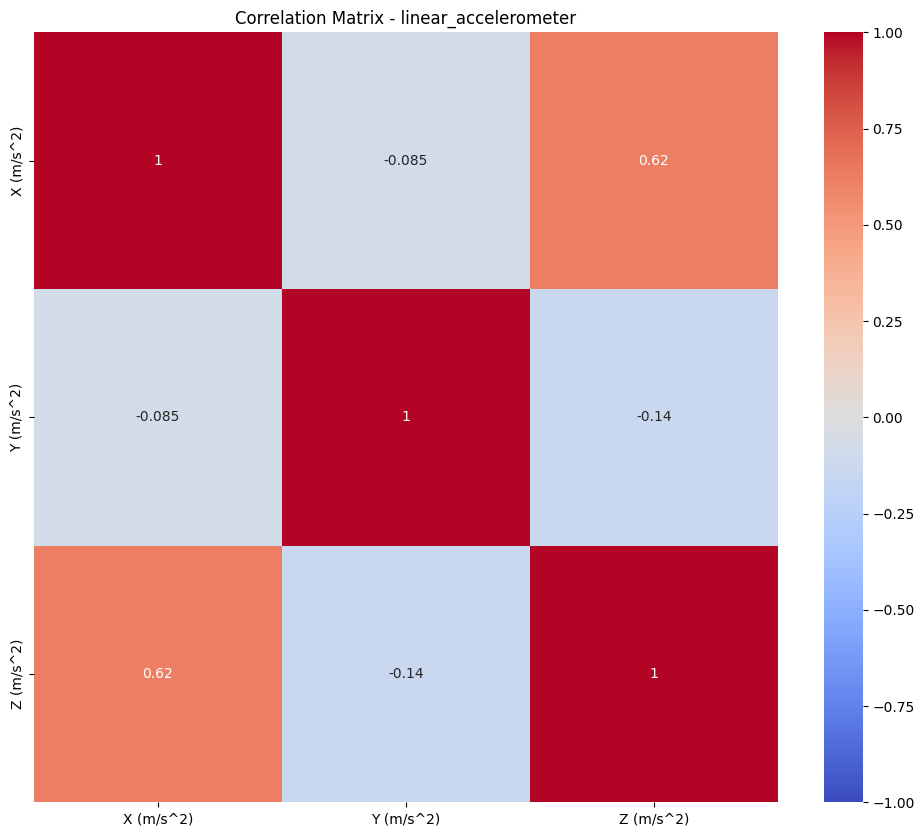

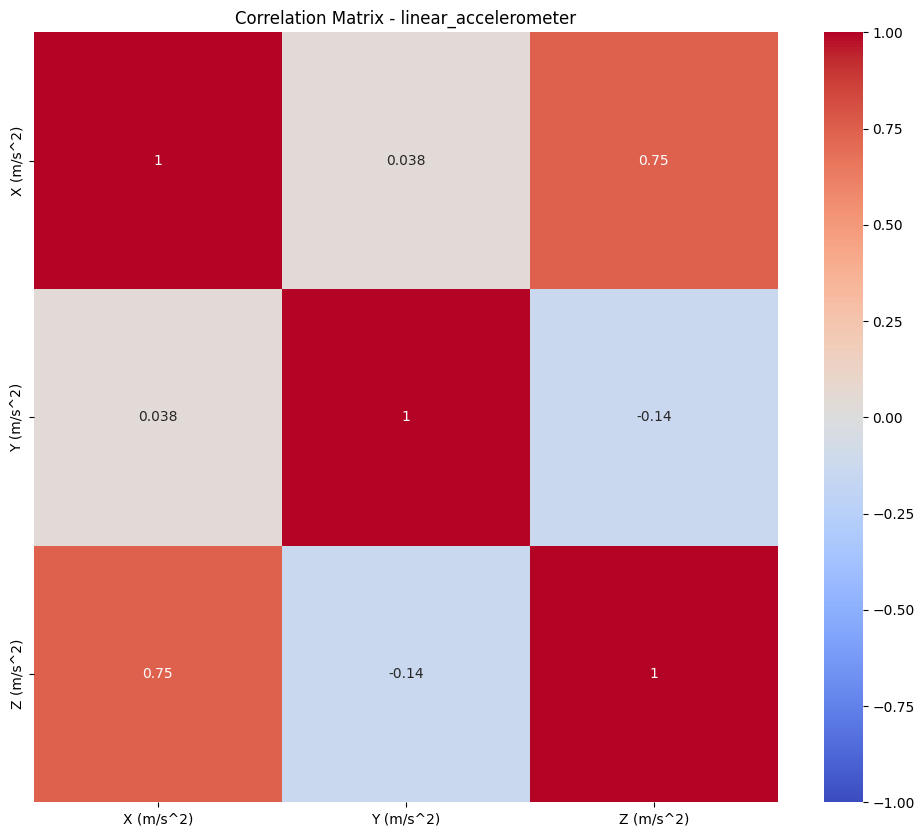

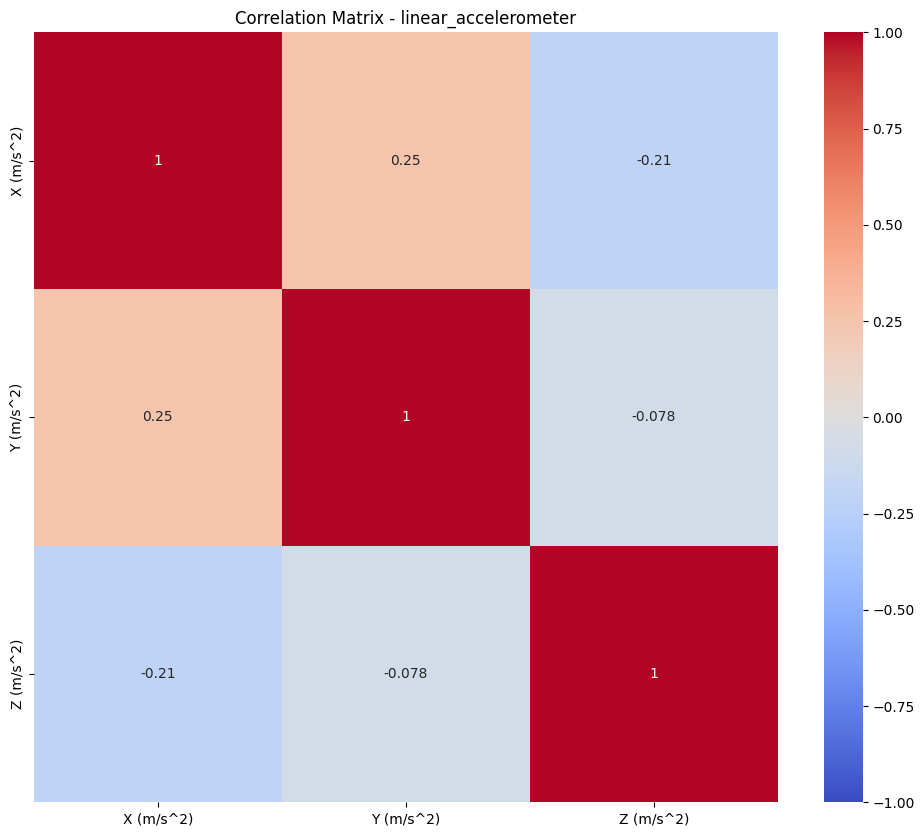

Correlation Matrix for magnetometer:


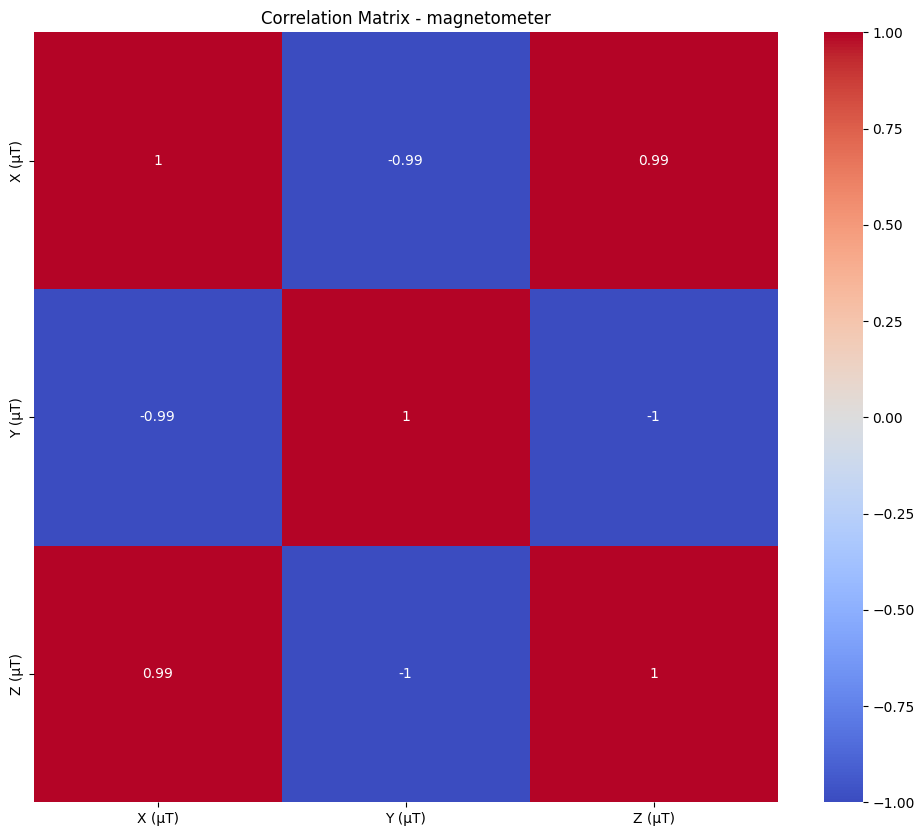

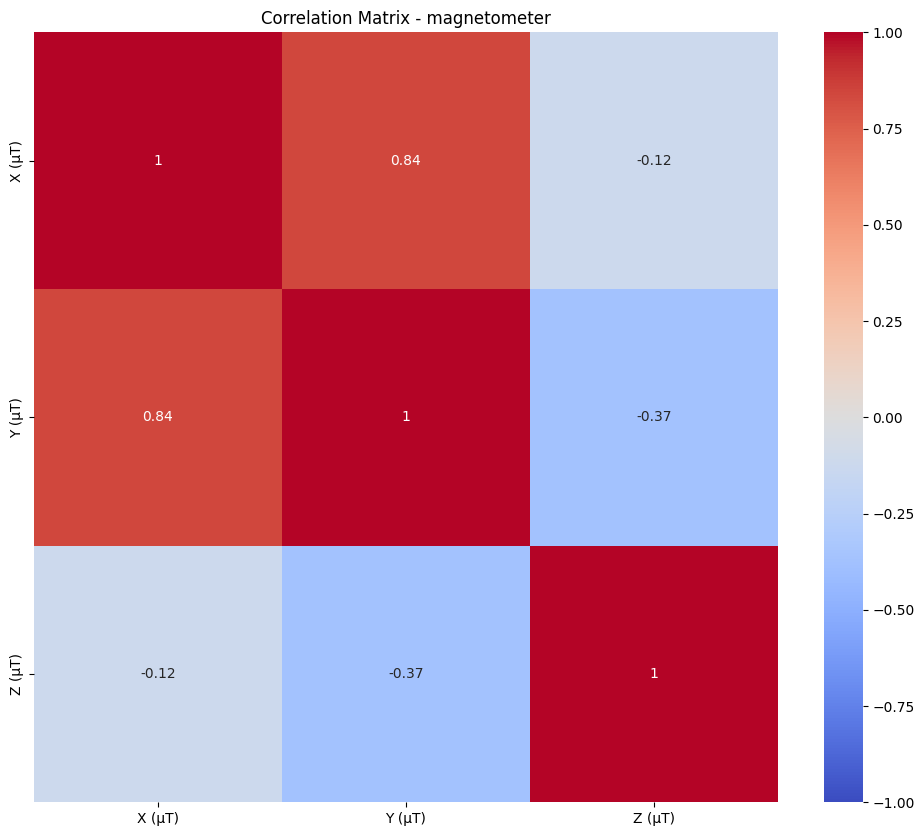

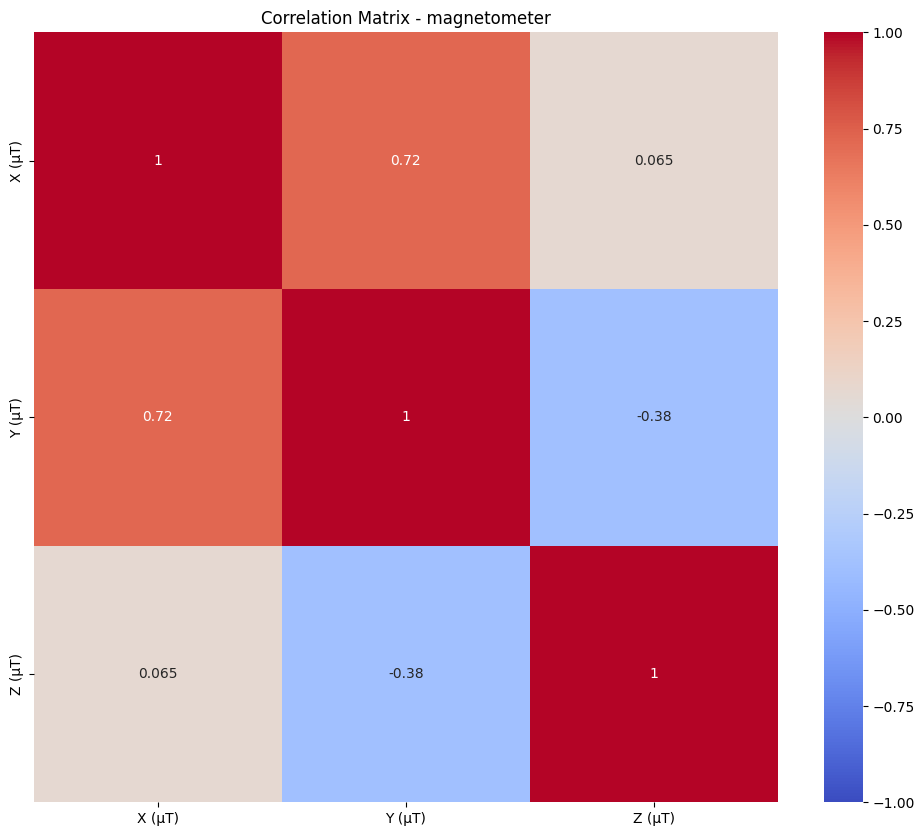

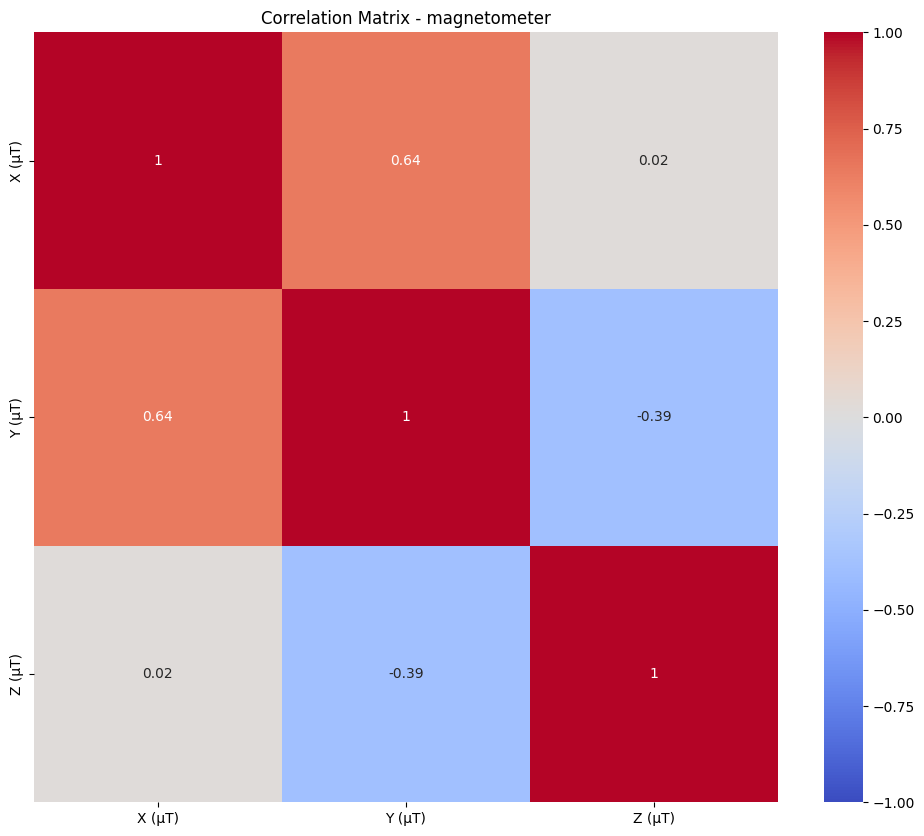

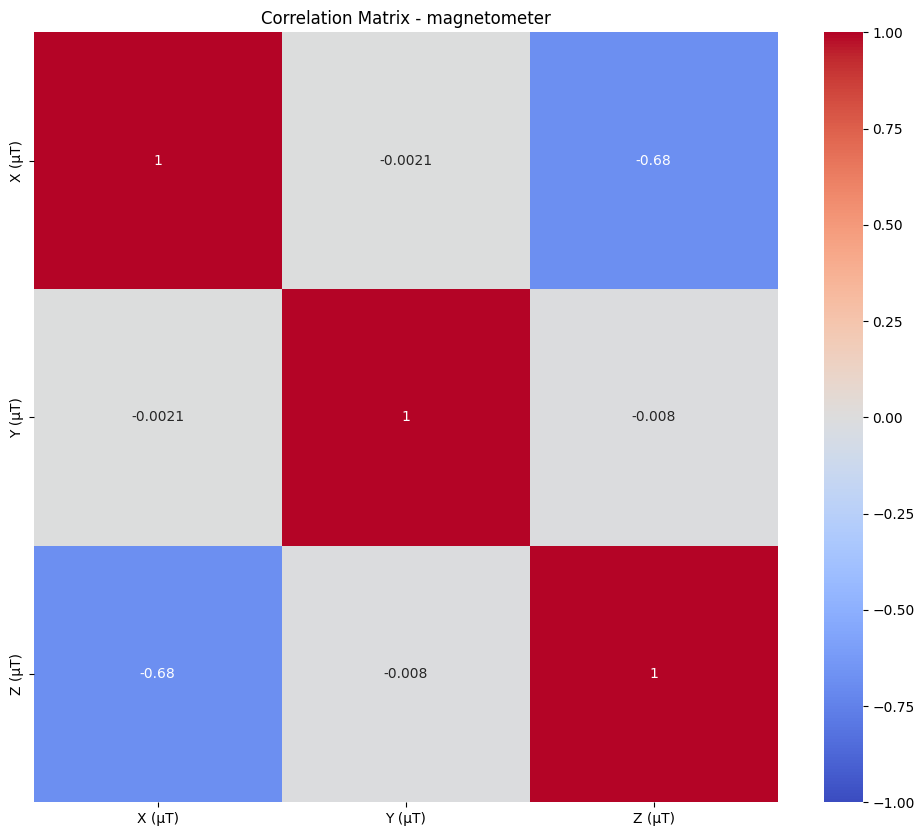

In [11]:

# Compute and visualize the correlation matrix for numerical features
for sensor_type in sensor_types:
    print(f"Correlation Matrix for {sensor_type}:")
    for df in aggregated_data_dict[sensor_type]:
        numerical_cols = [col for col in df.columns if col not in ['time', 'label']]
        corr_matrix = df[numerical_cols].corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f'Correlation Matrix - {sensor_type}')
        plt.show()


Histograms for accelerometer:


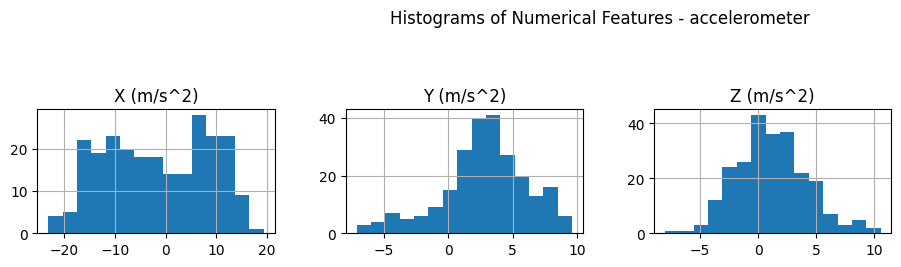

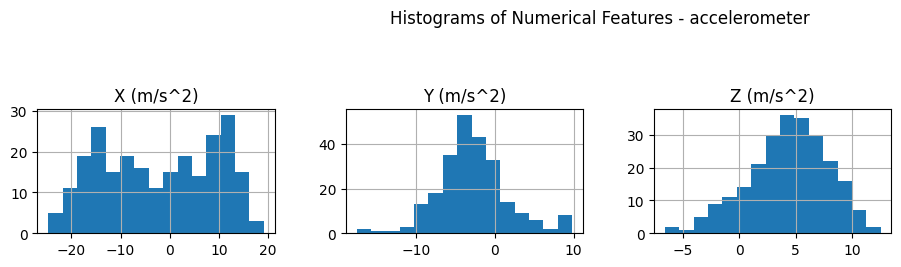

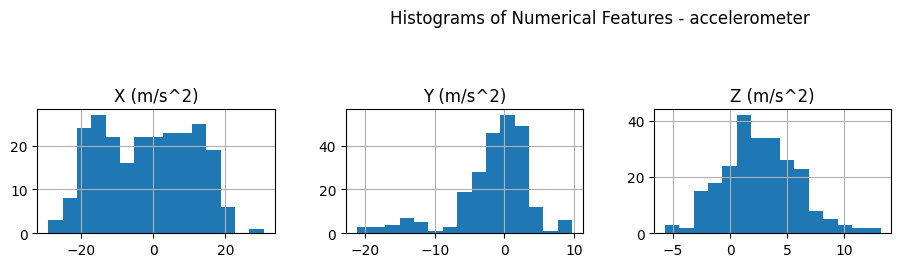

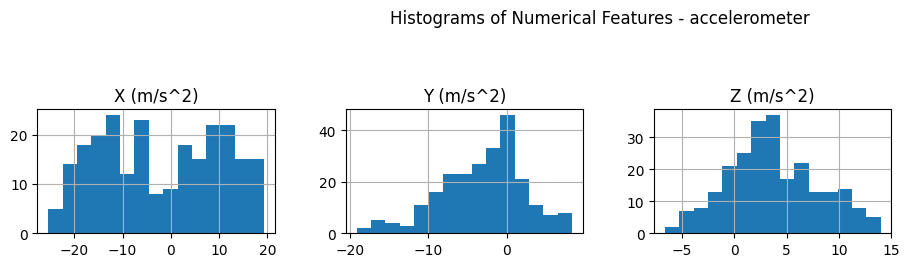

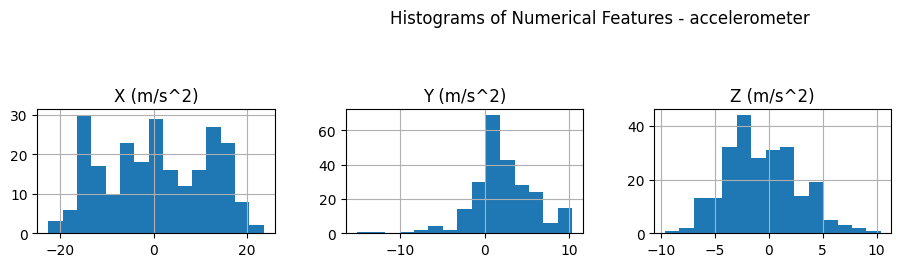

Histograms for gyroscope:


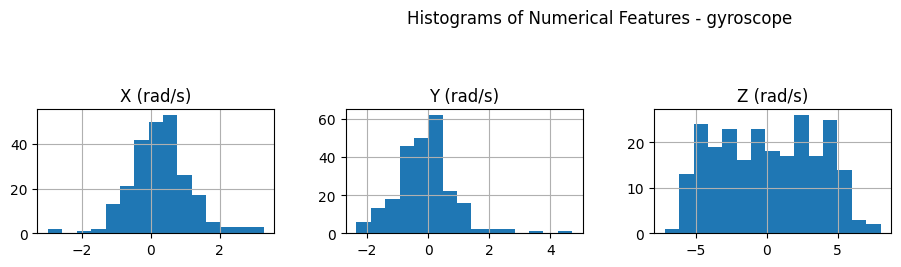

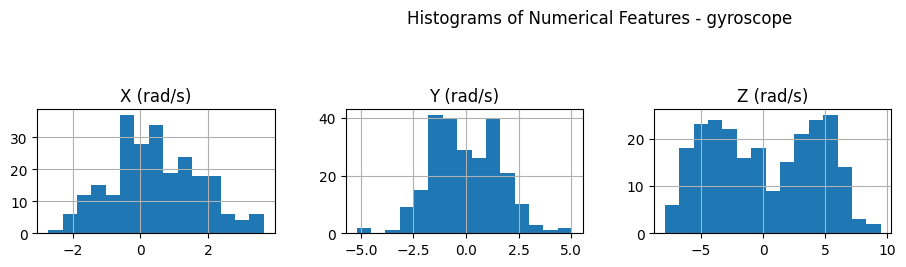

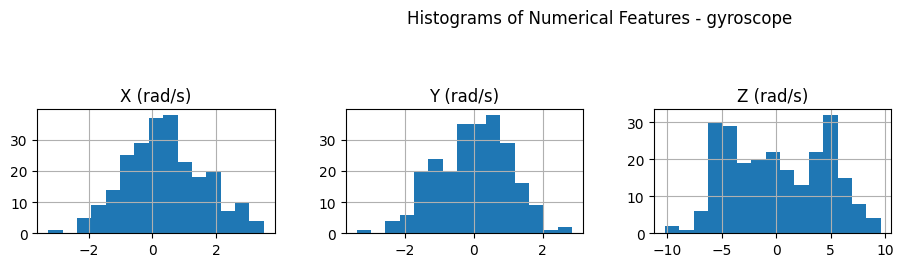

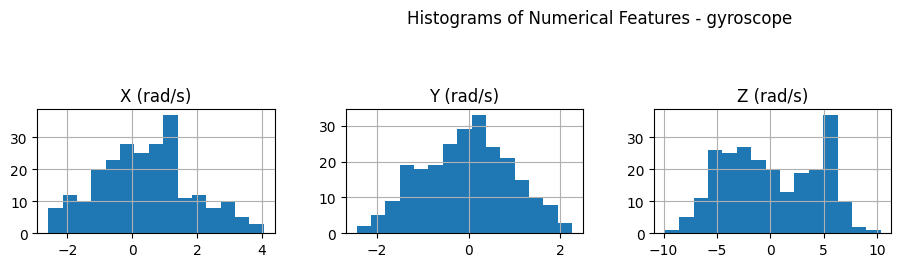

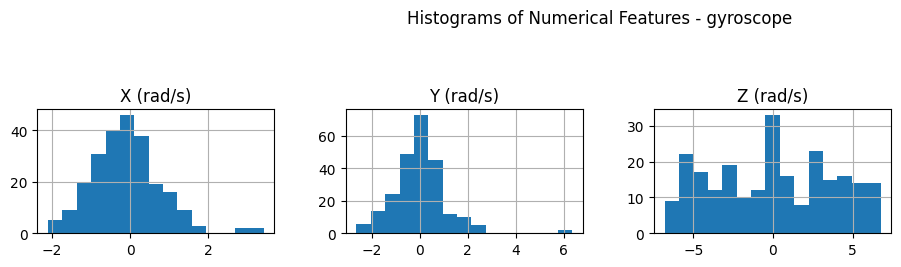

Histograms for linear_accelerometer:


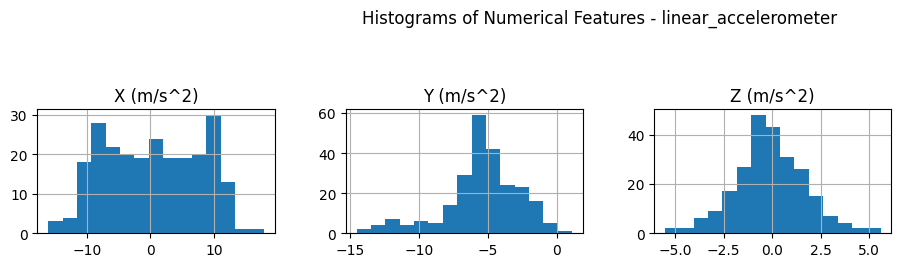

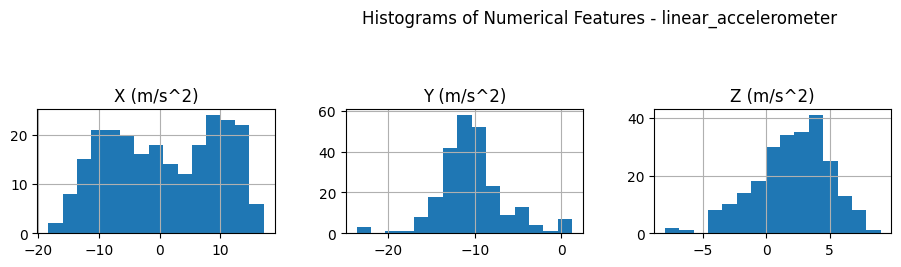

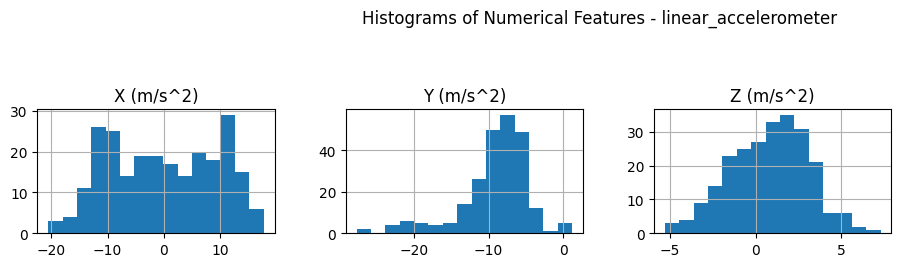

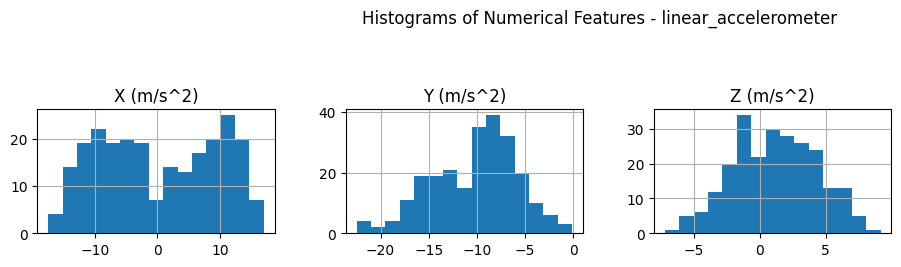

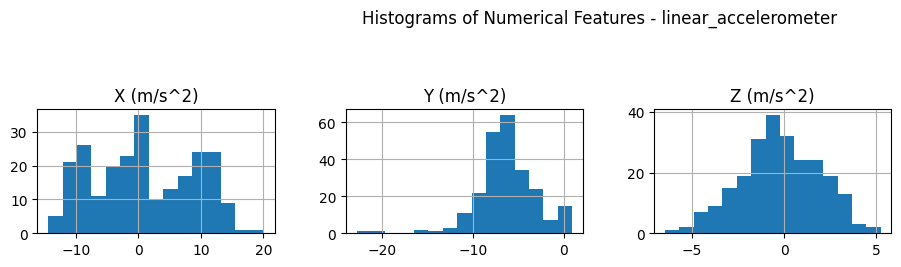

Histograms for magnetometer:


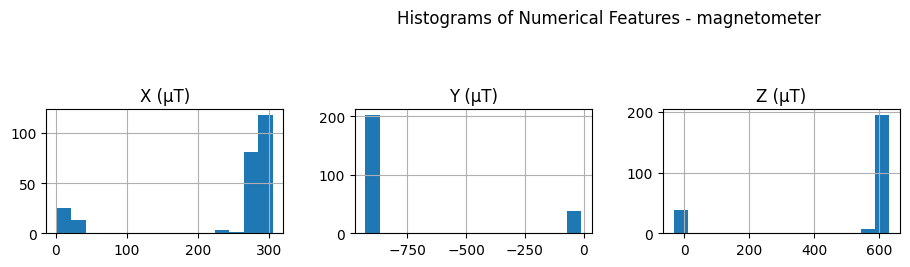

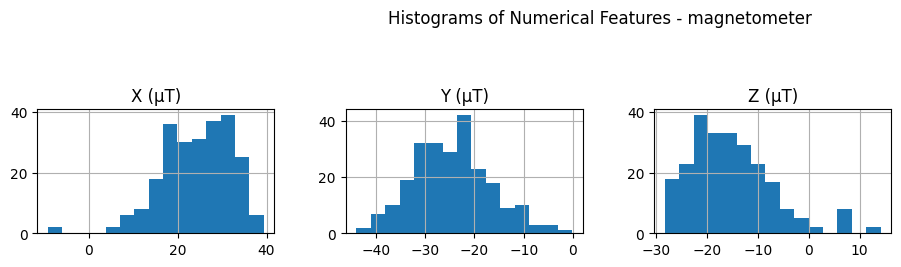

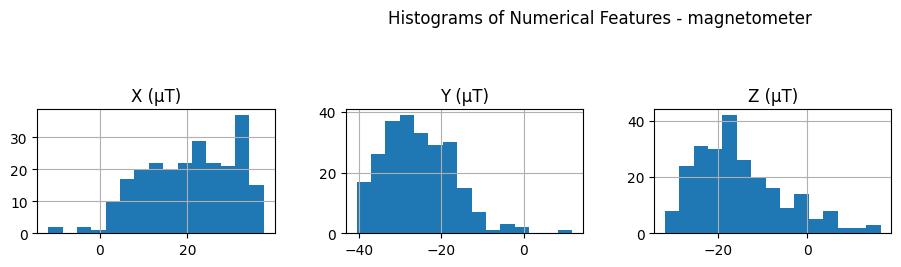

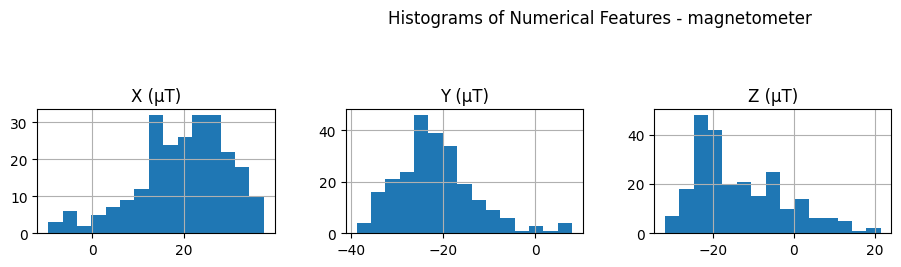

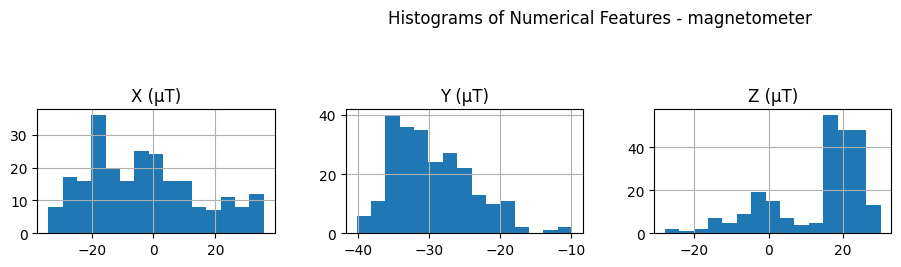

In [12]:
for sensor_type in sensor_types:
    print(f"Histograms for {sensor_type}:")
    for df in aggregated_data_dict[sensor_type]:
        numerical_cols = [col for col in df.columns if col not in ['time', 'label']]
        df[numerical_cols].hist(bins=15, figsize=(15, 10), layout=(5, 4))
        plt.suptitle(f'Histograms of Numerical Features - {sensor_type}')
        plt.show()

Time Series Plots for accelerometer:


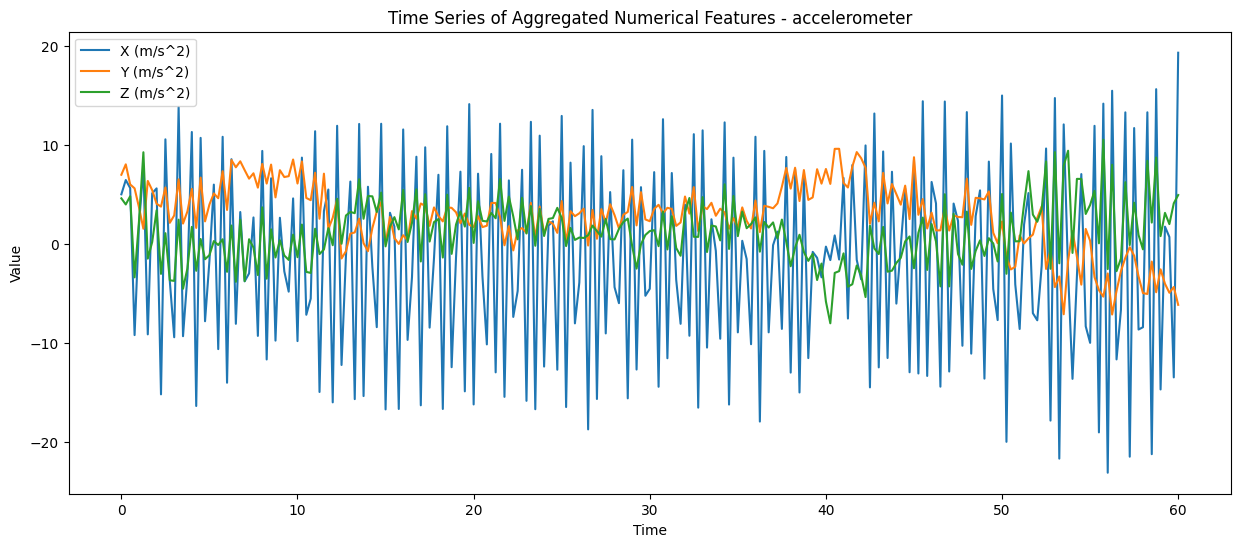

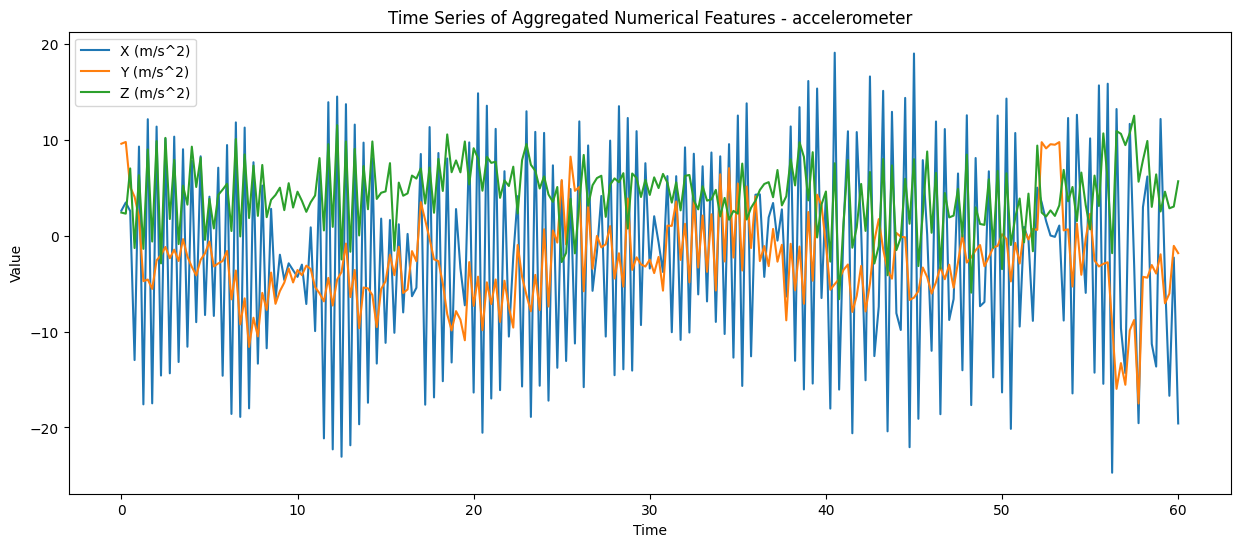

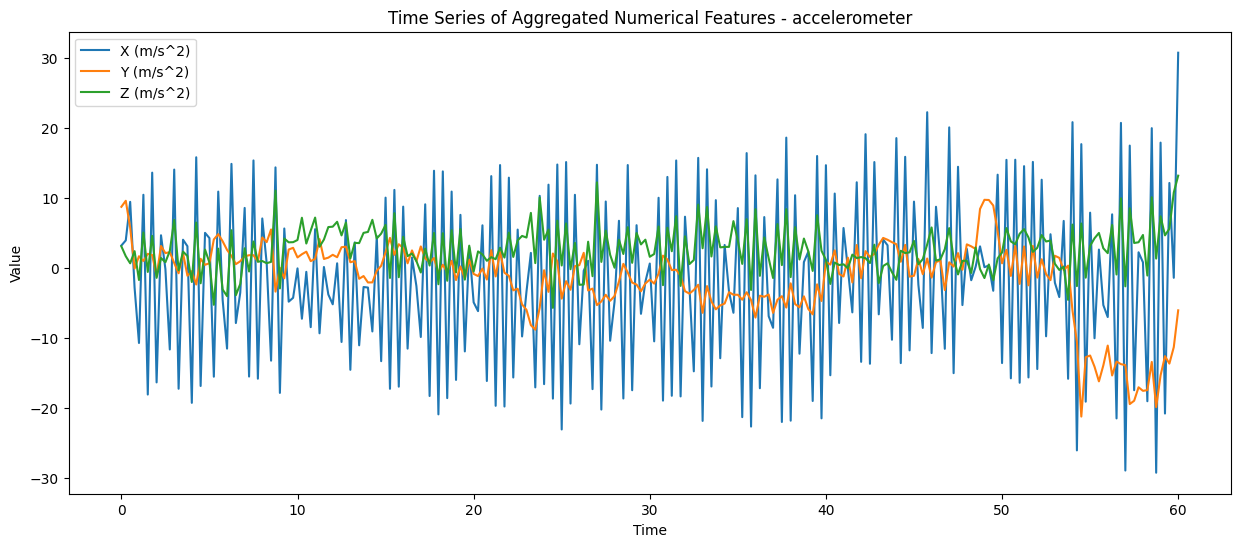

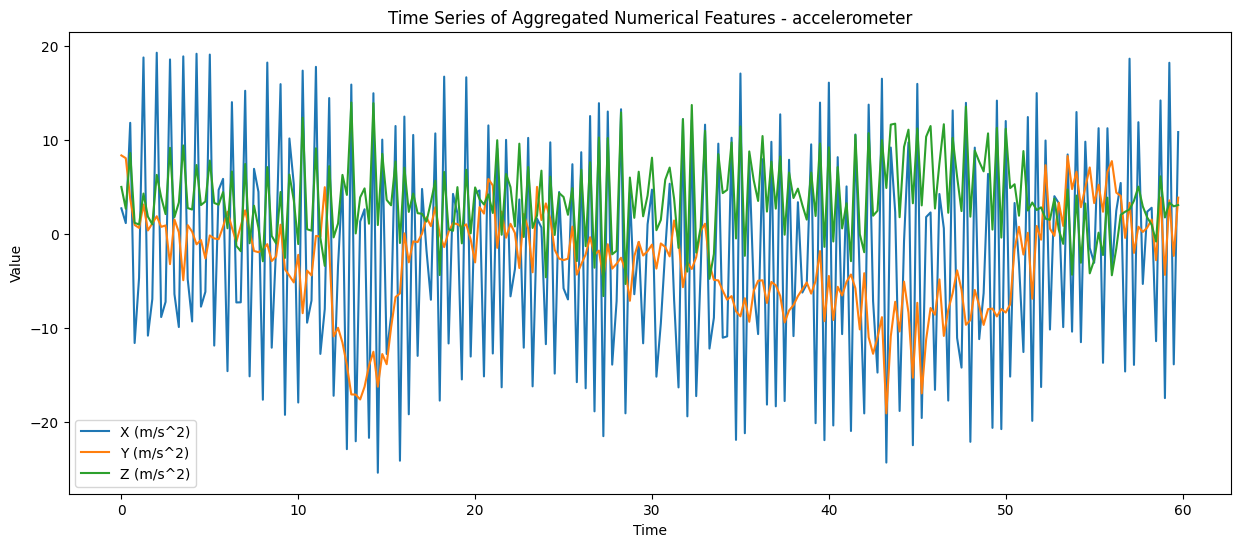

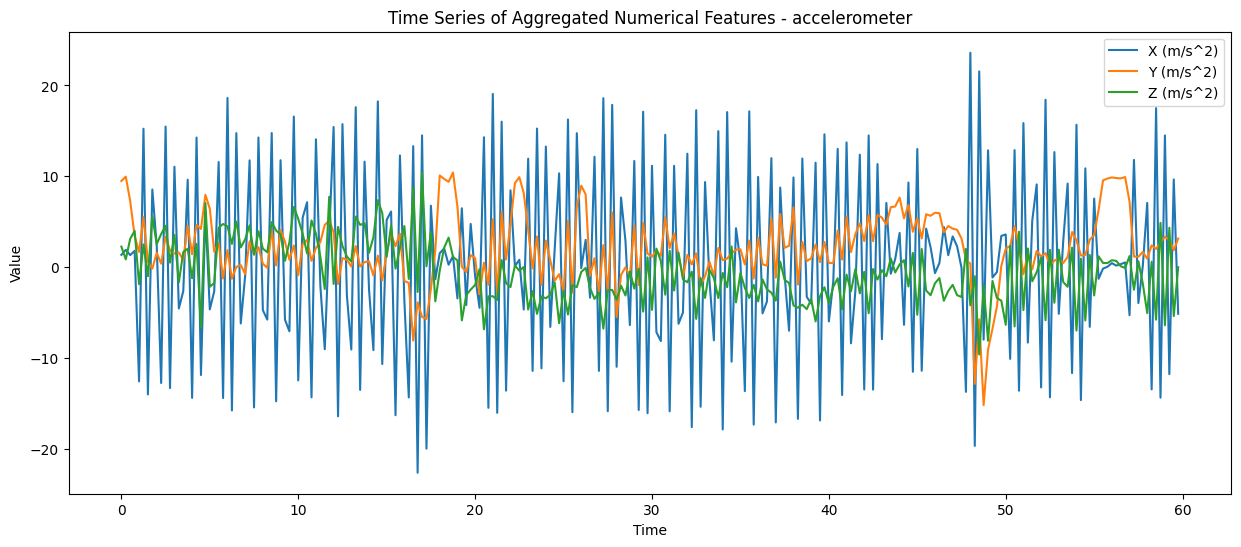

Time Series Plots for gyroscope:


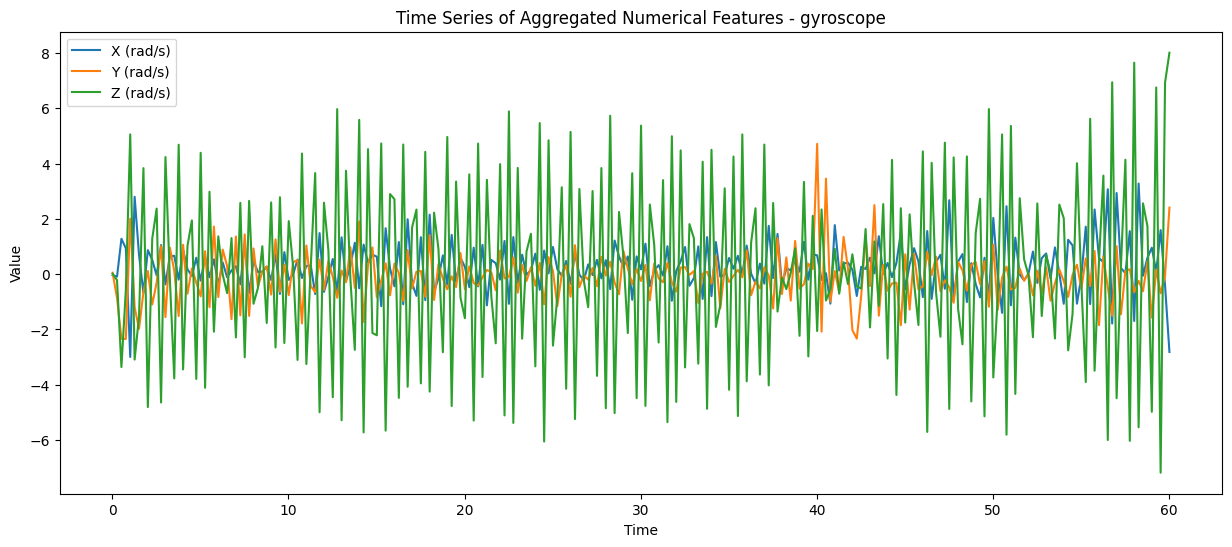

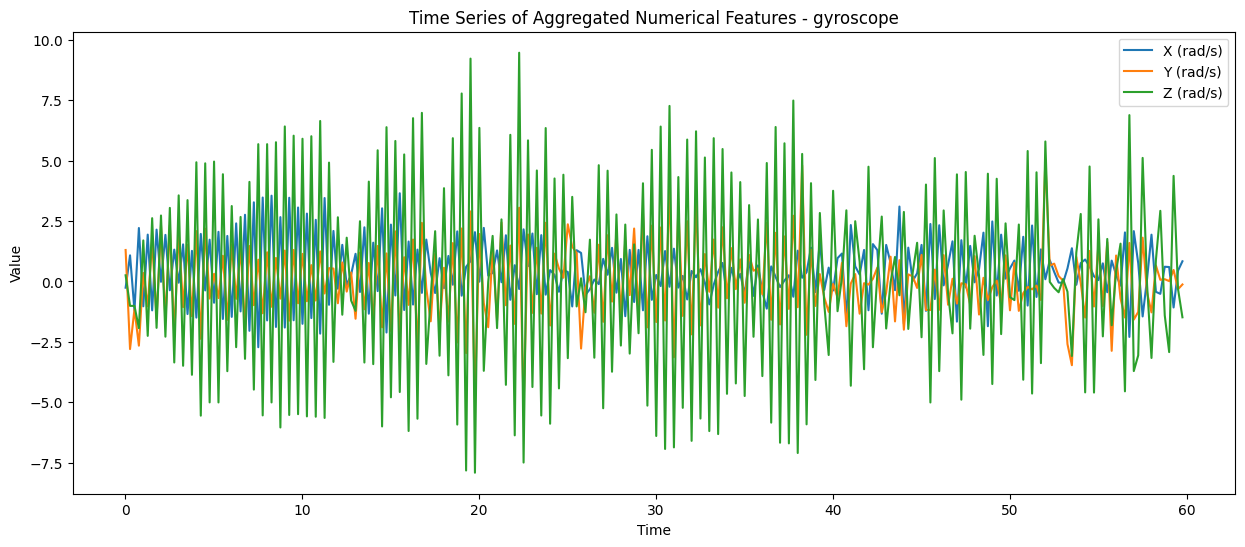

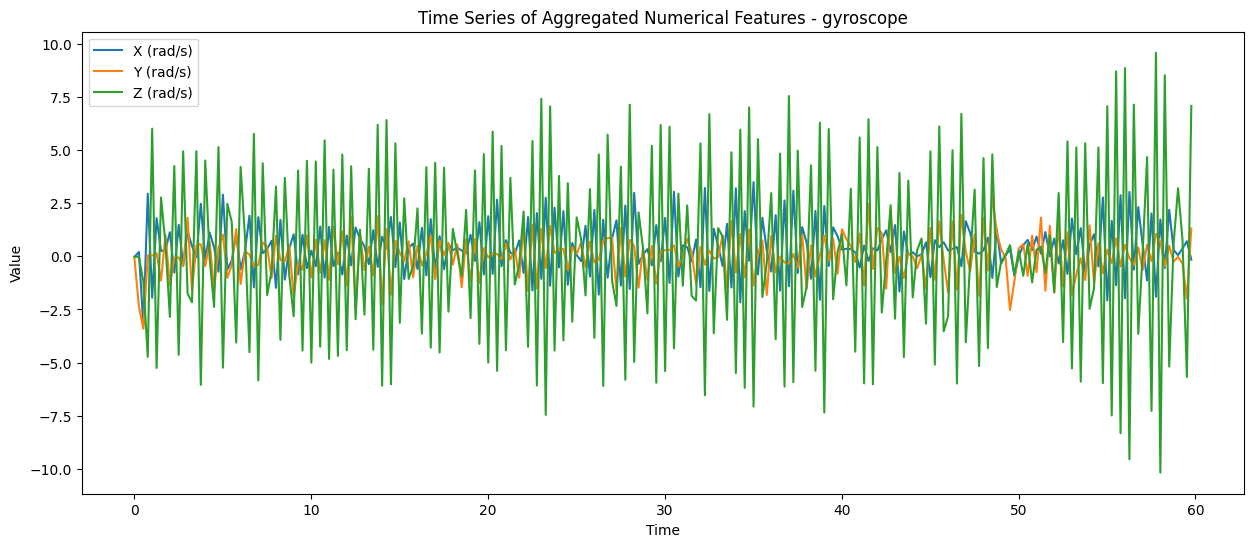

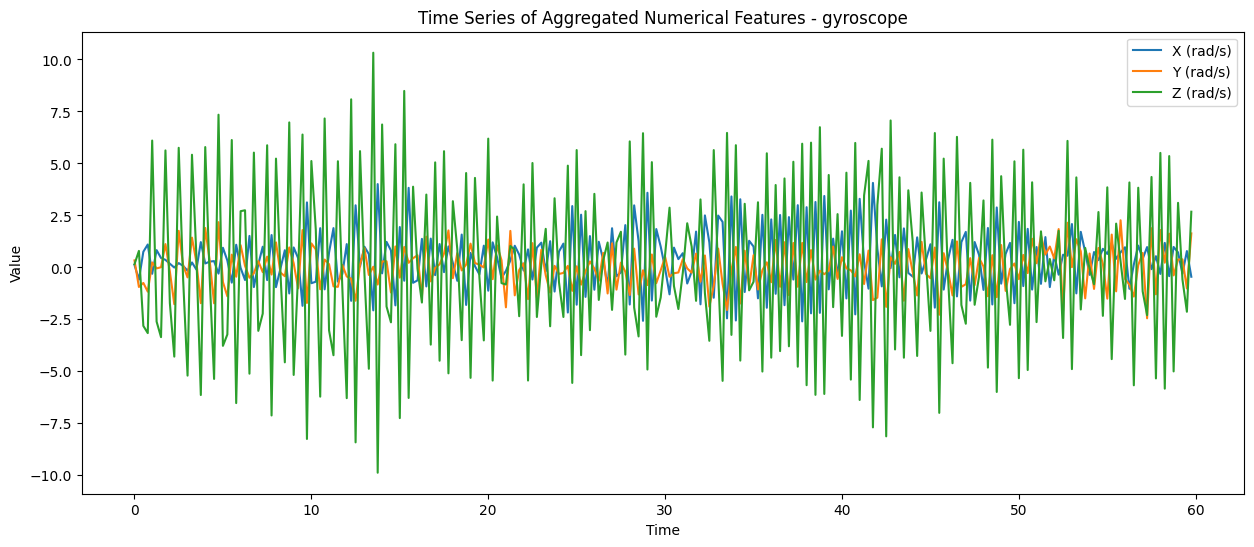

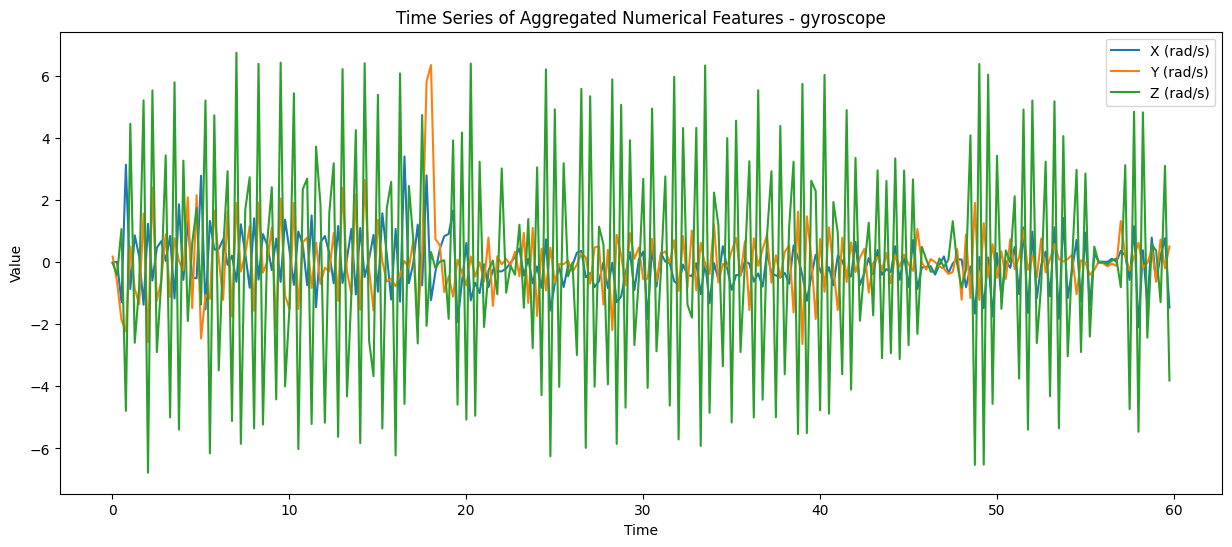

Time Series Plots for linear_accelerometer:


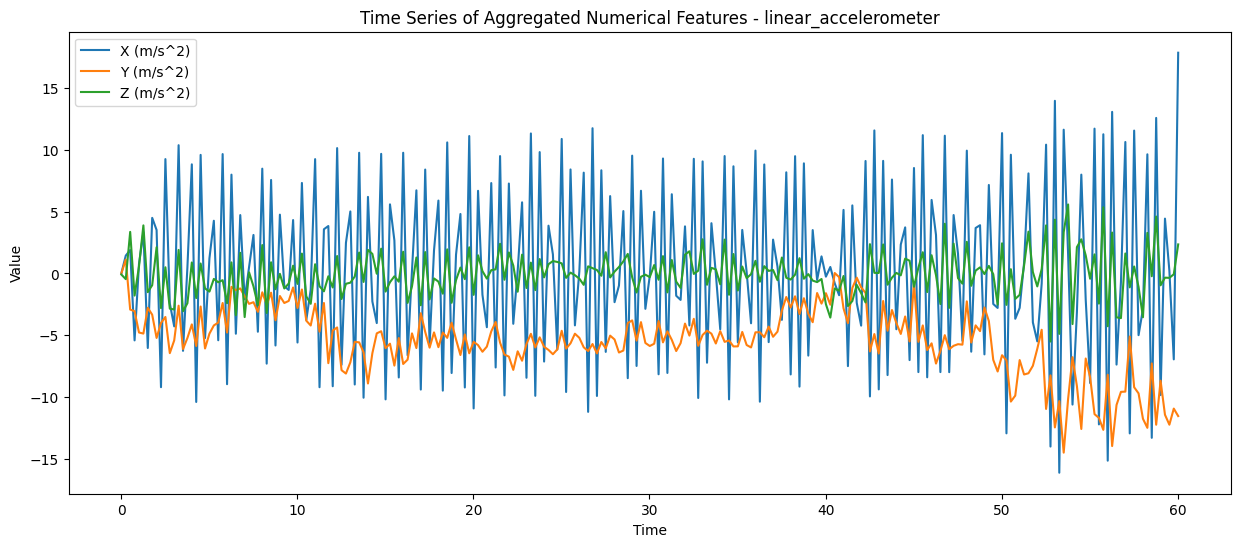

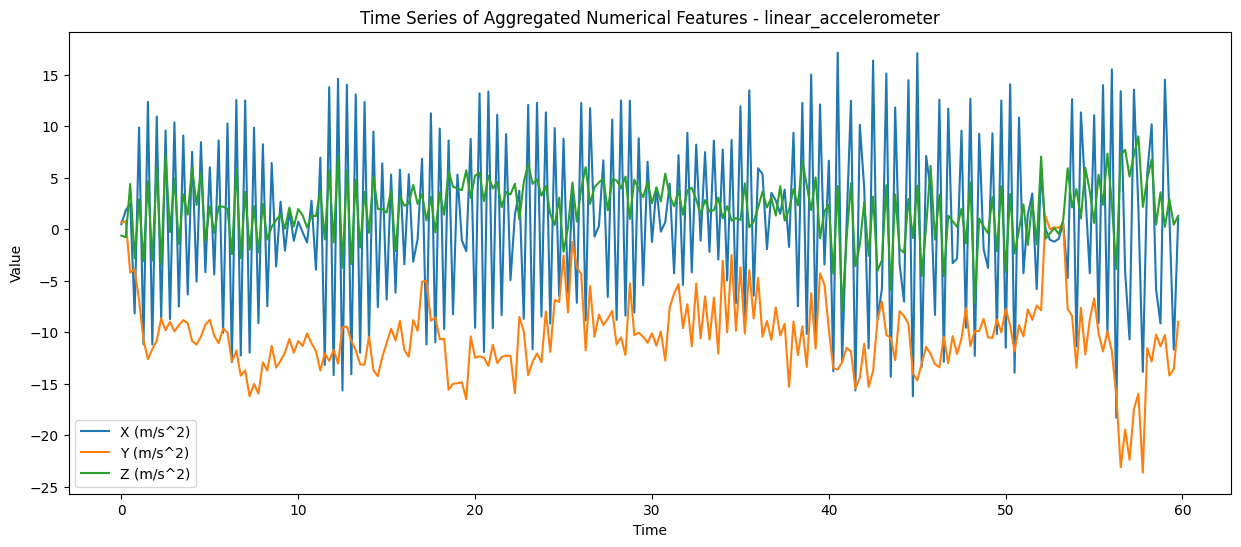

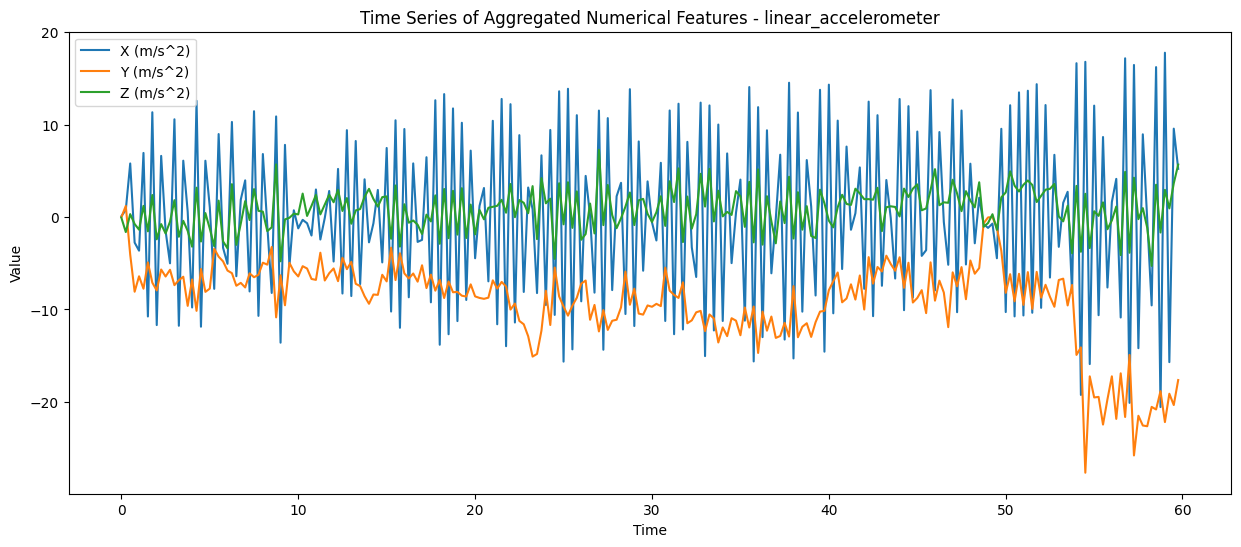

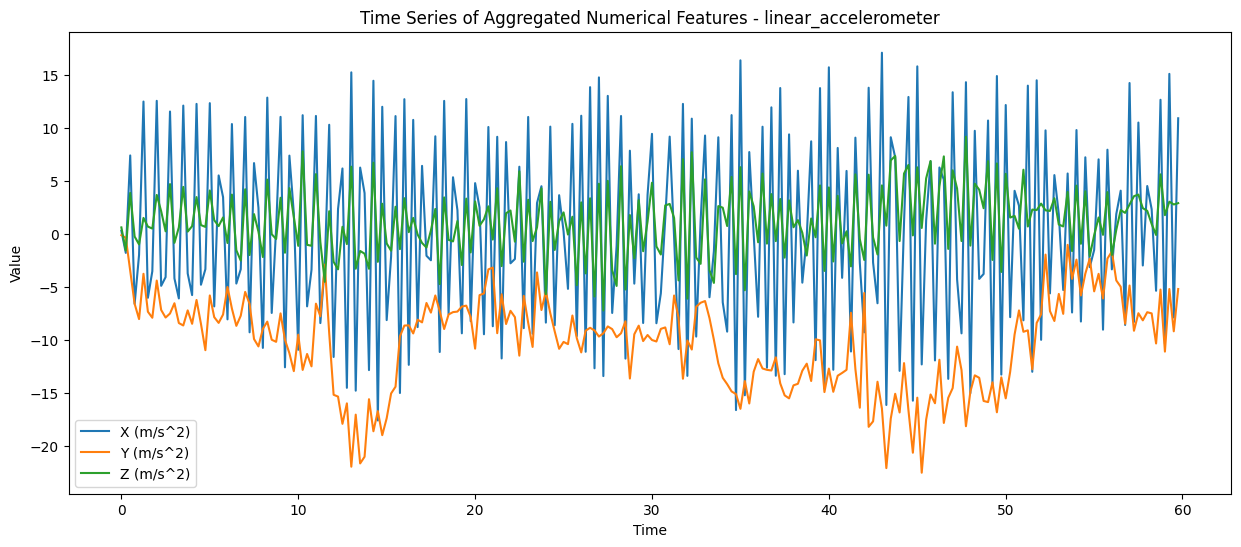

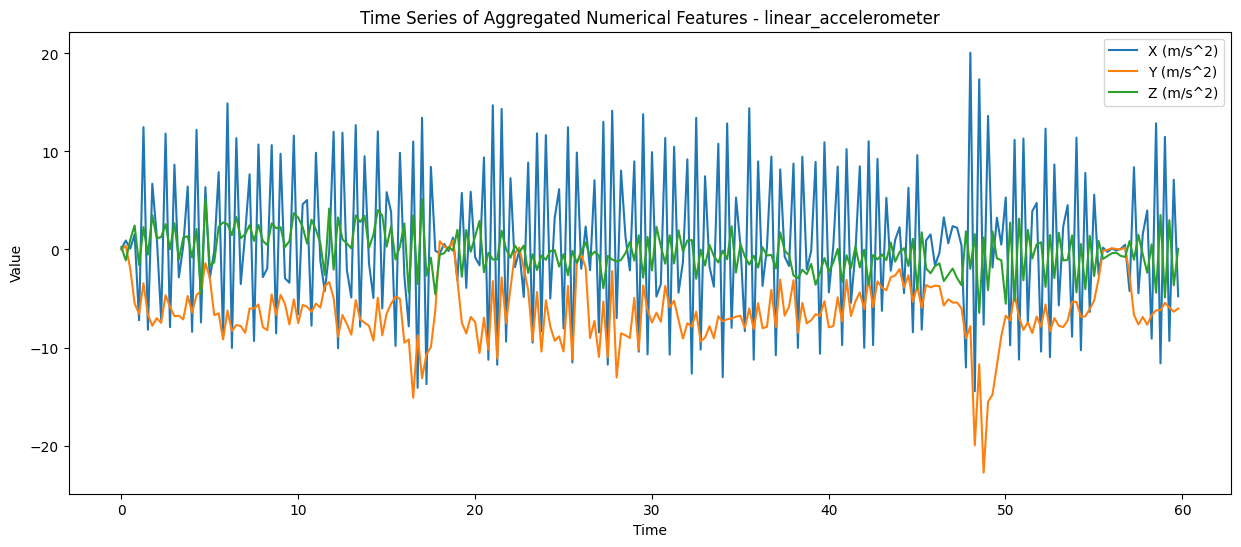

Time Series Plots for magnetometer:


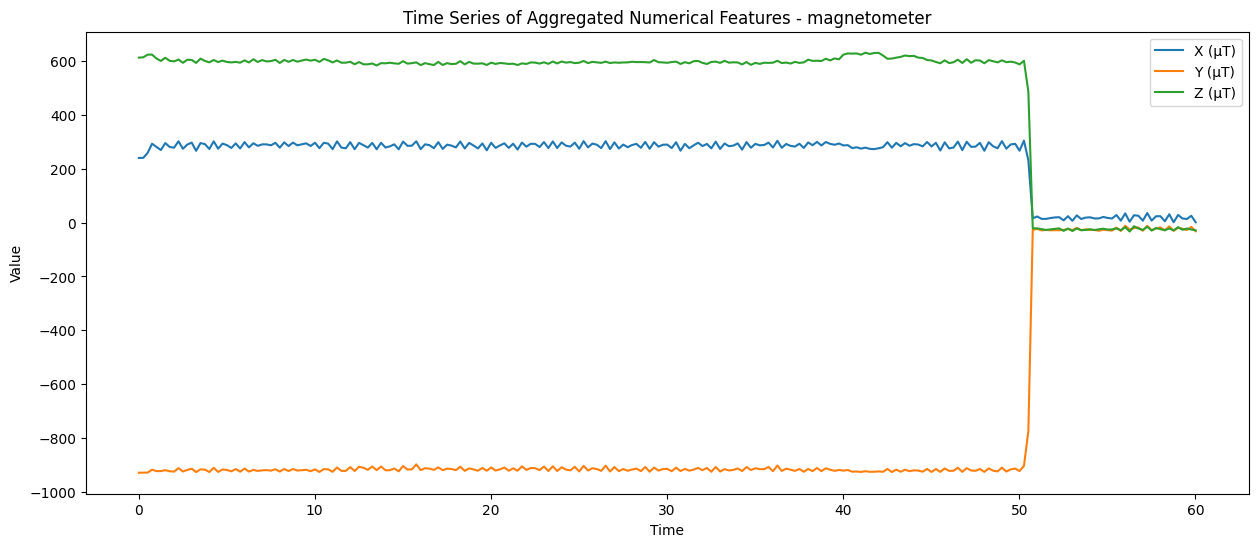

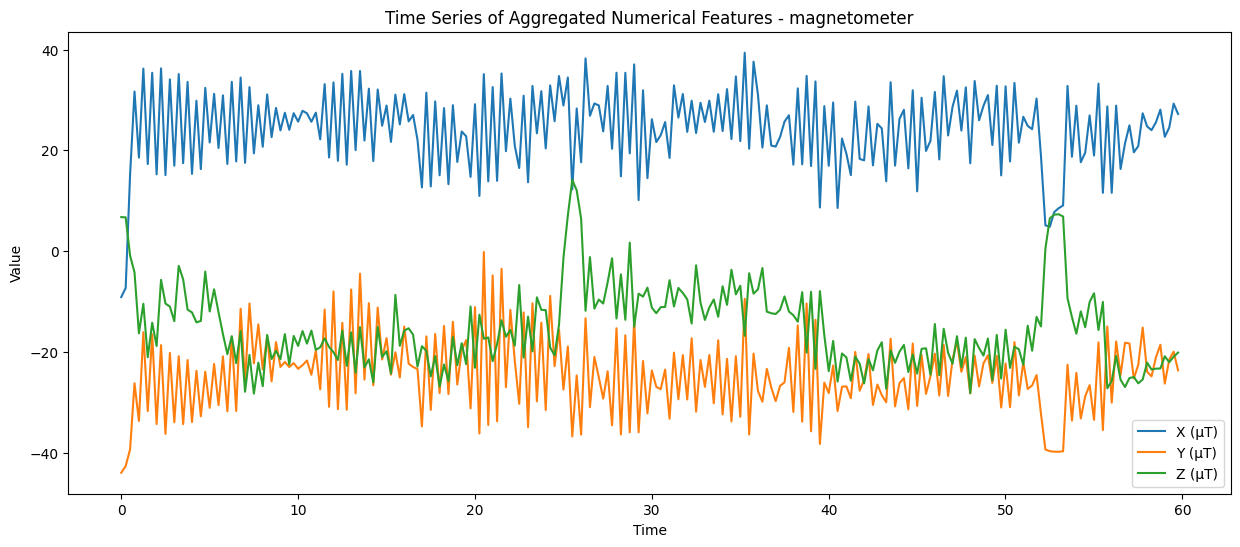

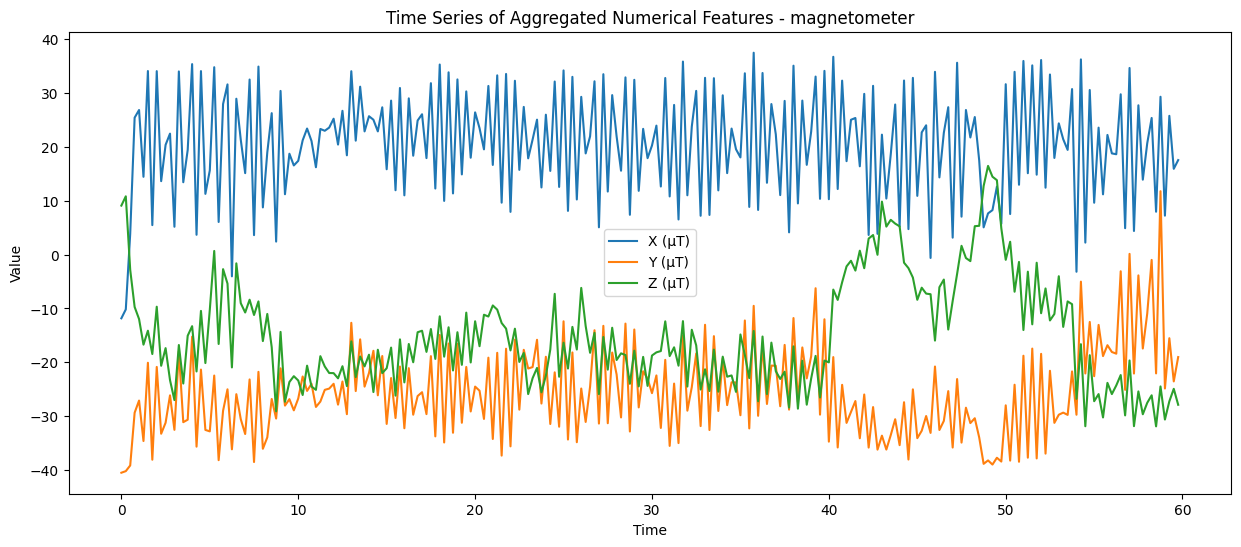

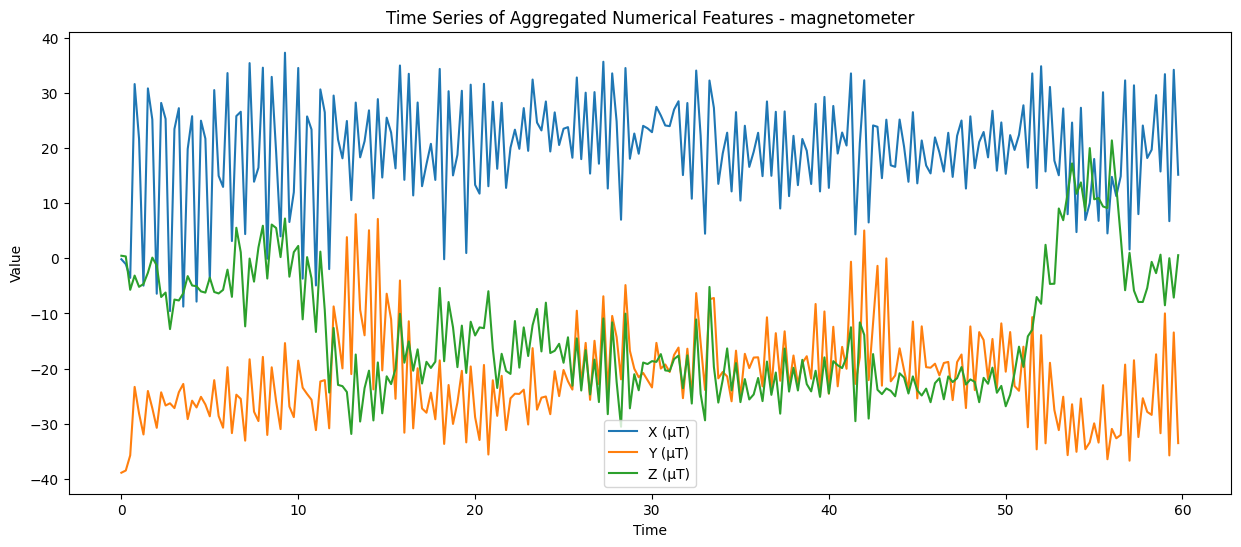

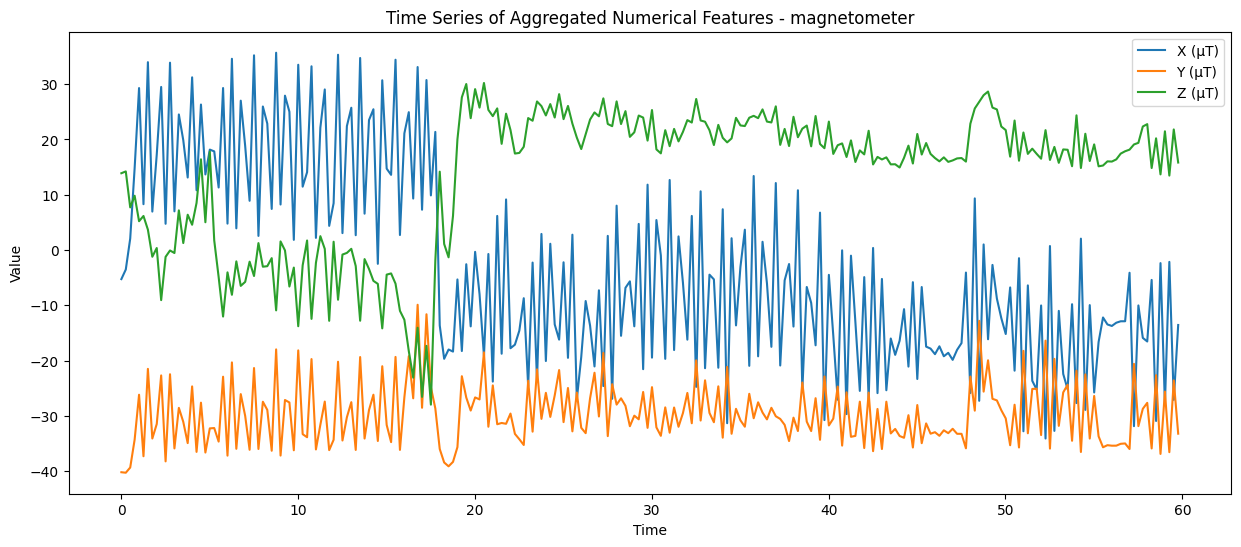

In [13]:
# Plot time series data for the aggregated numerical features
for sensor_type in sensor_types:
    print(f"Time Series Plots for {sensor_type}:")
    for df in aggregated_data_dict[sensor_type]:
        numerical_cols = [col for col in df.columns if col not in ['time', 'label']]
        
        plt.figure(figsize=(15, 6))
        for col in numerical_cols:
            plt.plot(df['time'], df[col], label=col)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Time Series of Aggregated Numerical Features - {sensor_type}')
        plt.legend()
        plt.show()


# Normality check

Accelerometer Data Normality Check:


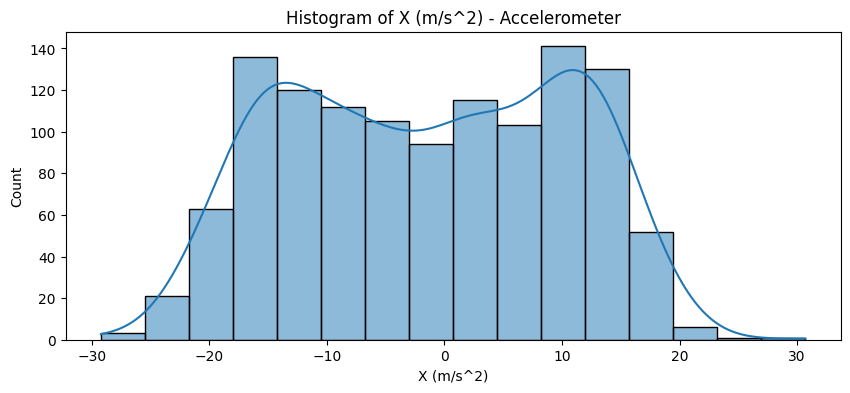

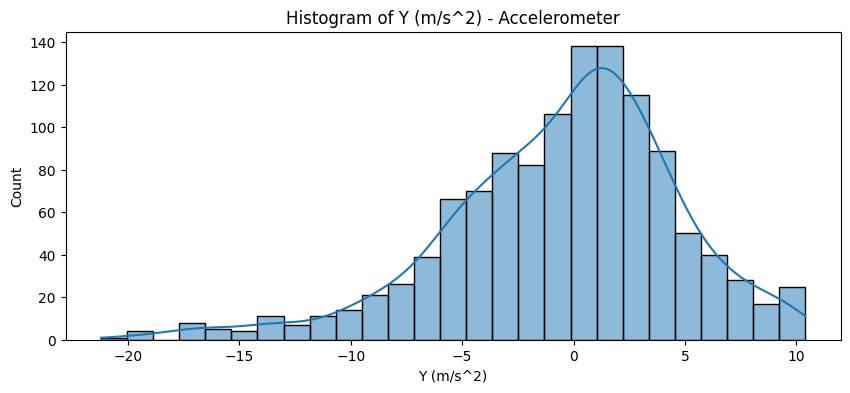

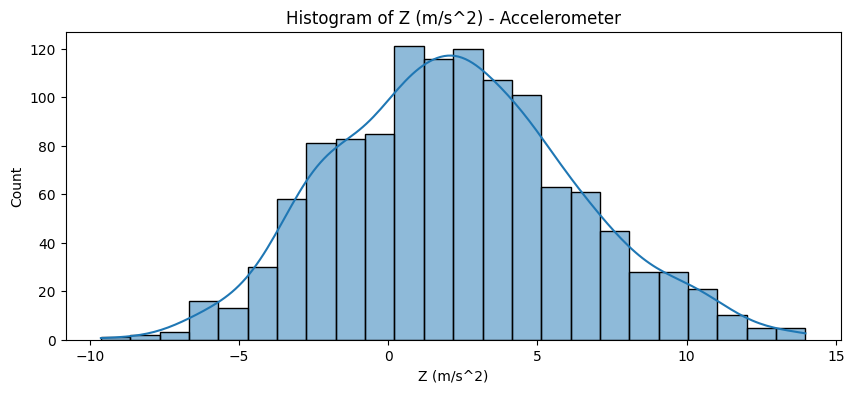

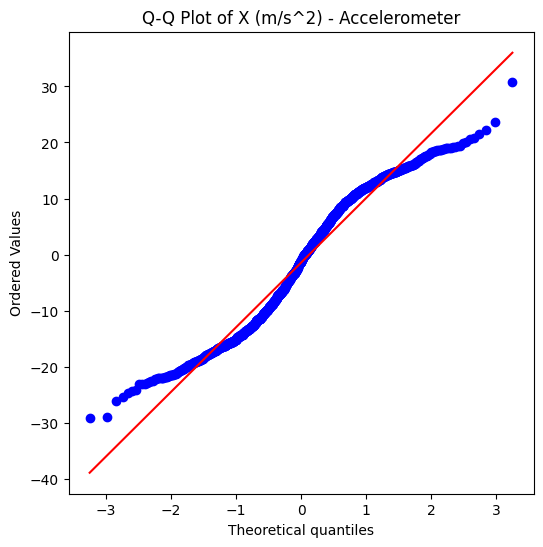

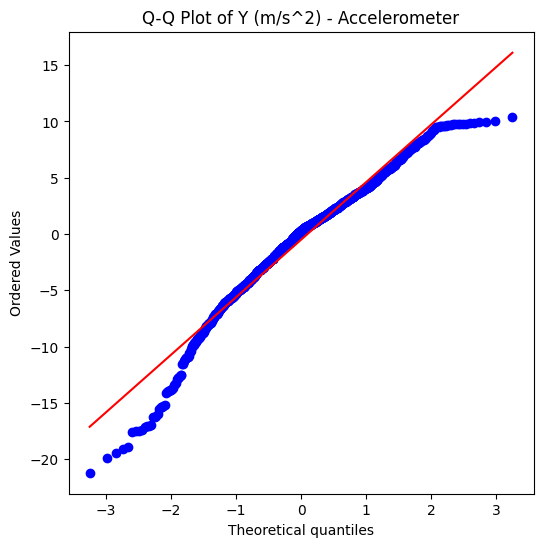

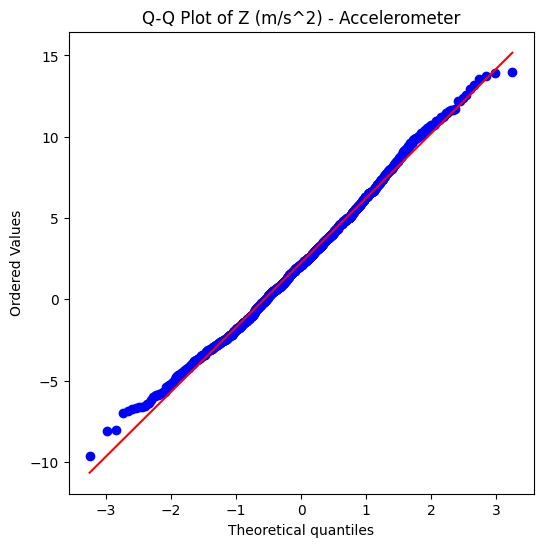

Shapiro-Wilk Test for X (m/s^2) - Accelerometer: Statistics=9.623e-01, p=4.218e-17
X (m/s^2) - Accelerometer does not look Gaussian (reject H0)
Shapiro-Wilk Test for Y (m/s^2) - Accelerometer: Statistics=9.680e-01, p=1.188e-15
Y (m/s^2) - Accelerometer does not look Gaussian (reject H0)
Shapiro-Wilk Test for Z (m/s^2) - Accelerometer: Statistics=9.957e-01, p=1.804e-03
Z (m/s^2) - Accelerometer does not look Gaussian (reject H0)

Gyroscope Data Normality Check:


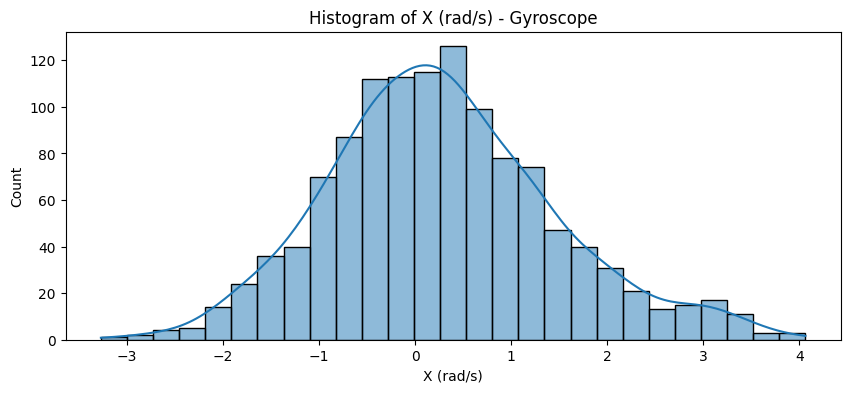

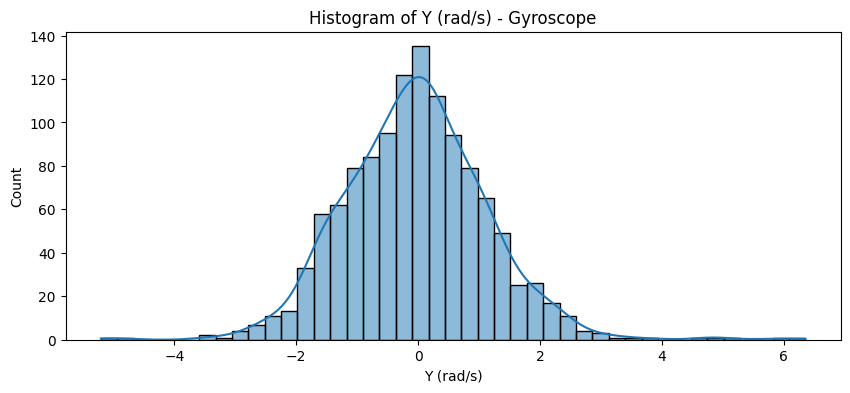

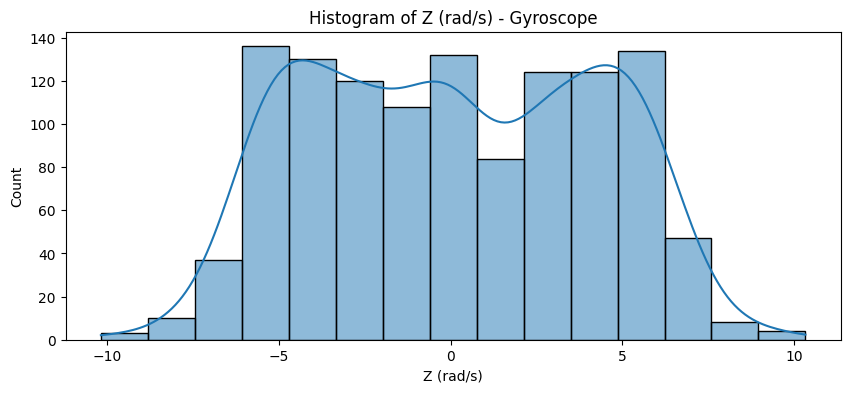

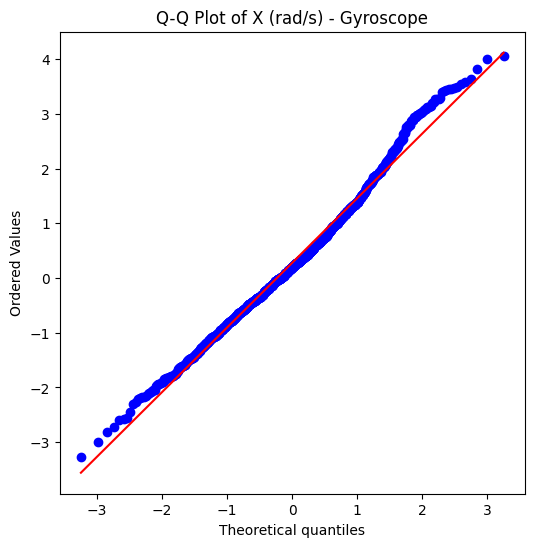

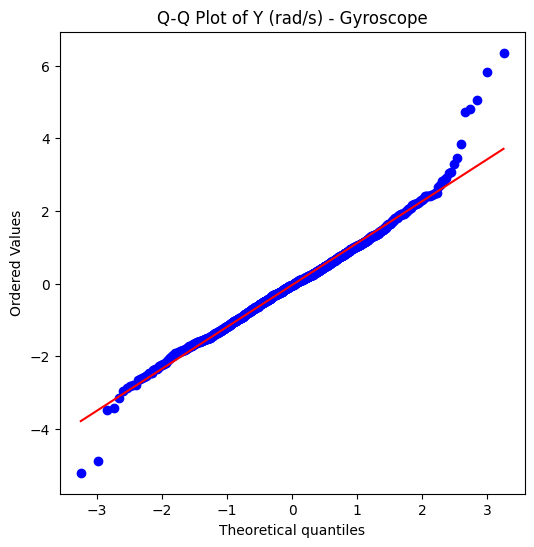

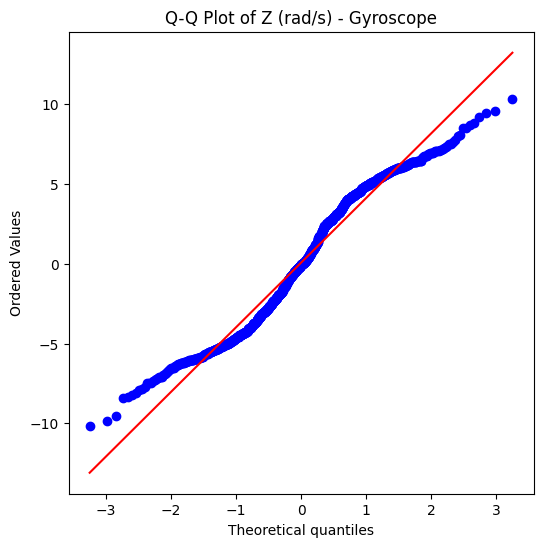

Shapiro-Wilk Test for X (rad/s) - Gyroscope: Statistics=9.899e-01, p=2.331e-07
X (rad/s) - Gyroscope does not look Gaussian (reject H0)
Shapiro-Wilk Test for Y (rad/s) - Gyroscope: Statistics=9.821e-01, p=5.328e-11
Y (rad/s) - Gyroscope does not look Gaussian (reject H0)
Shapiro-Wilk Test for Z (rad/s) - Gyroscope: Statistics=9.655e-01, p=2.821e-16
Z (rad/s) - Gyroscope does not look Gaussian (reject H0)

Linear Accelerometer Data Normality Check:


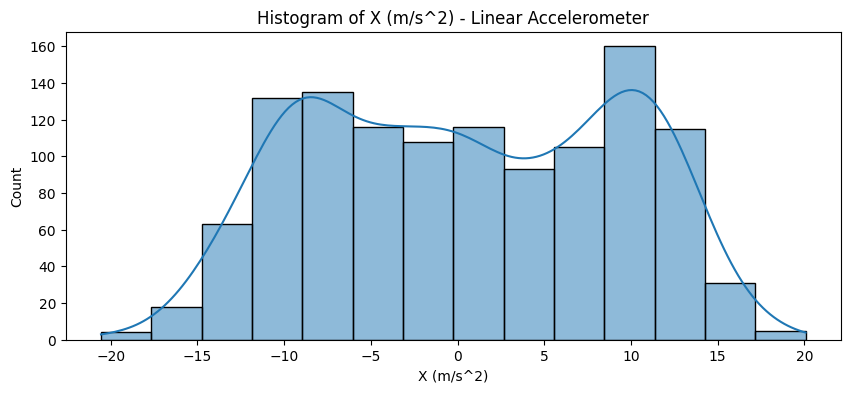

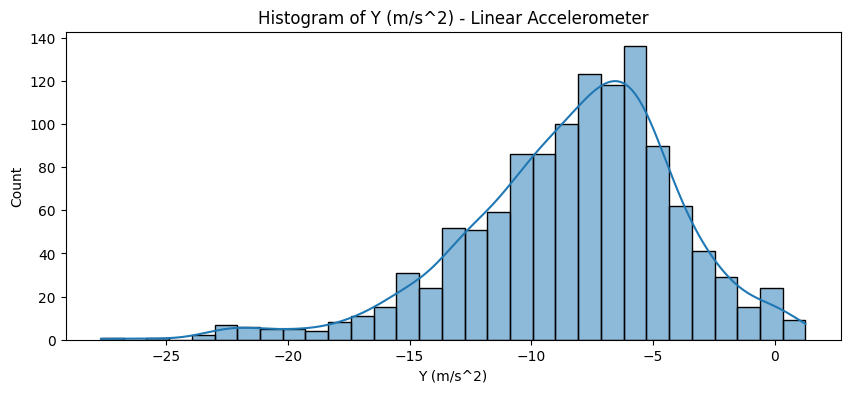

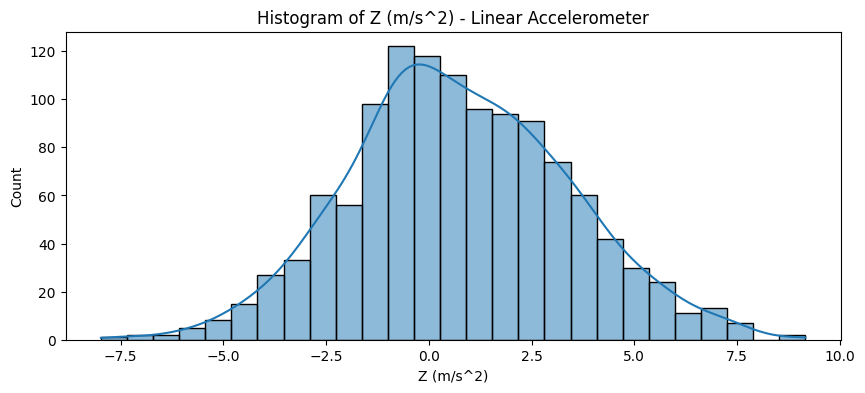

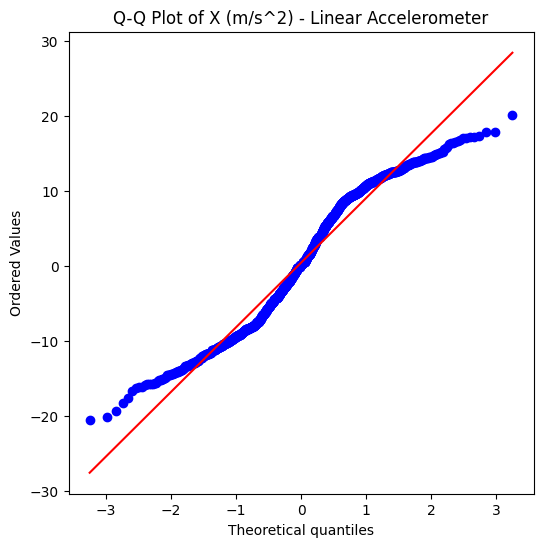

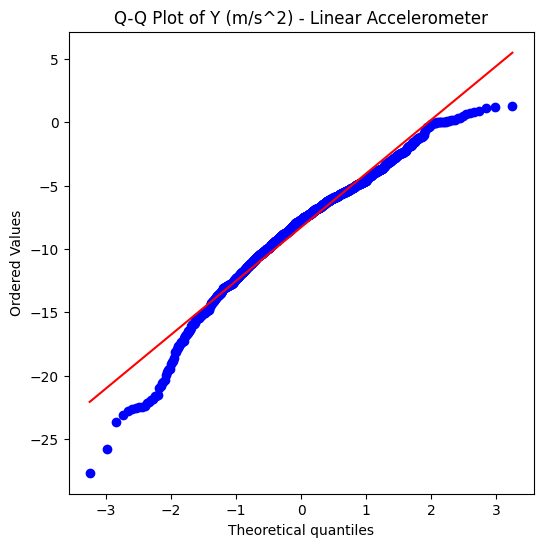

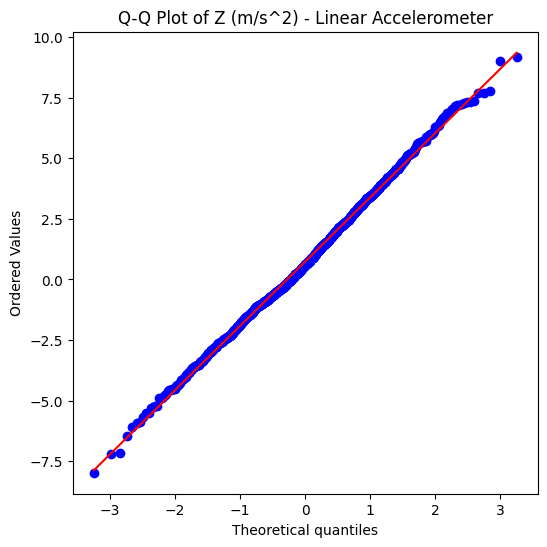

Shapiro-Wilk Test for X (m/s^2) - Linear Accelerometer: Statistics=9.609e-01, p=2.042e-17
X (m/s^2) - Linear Accelerometer does not look Gaussian (reject H0)
Shapiro-Wilk Test for Y (m/s^2) - Linear Accelerometer: Statistics=9.682e-01, p=1.437e-15
Y (m/s^2) - Linear Accelerometer does not look Gaussian (reject H0)
Shapiro-Wilk Test for Z (m/s^2) - Linear Accelerometer: Statistics=9.981e-01, p=1.954e-01
Z (m/s^2) - Linear Accelerometer looks Gaussian (fail to reject H0)

Magnetometer Data Normality Check:


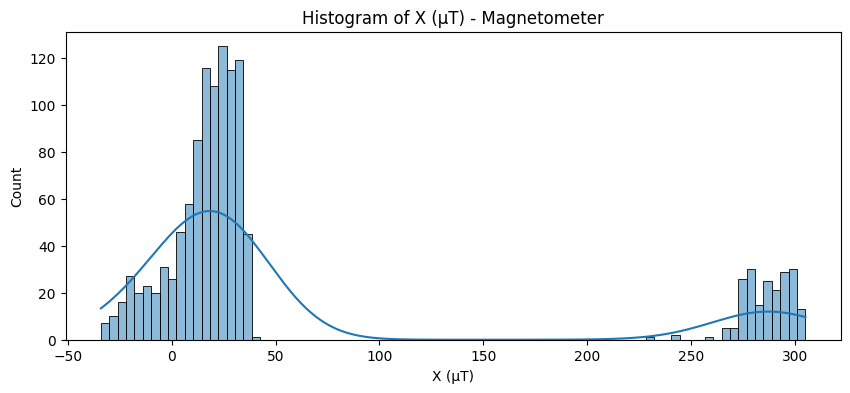

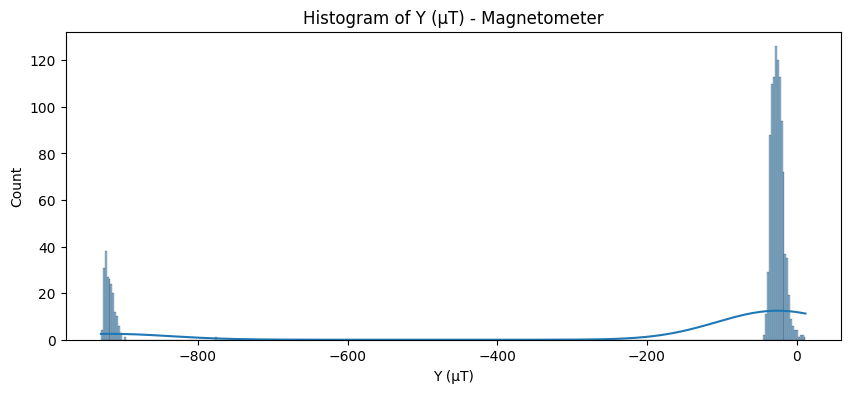

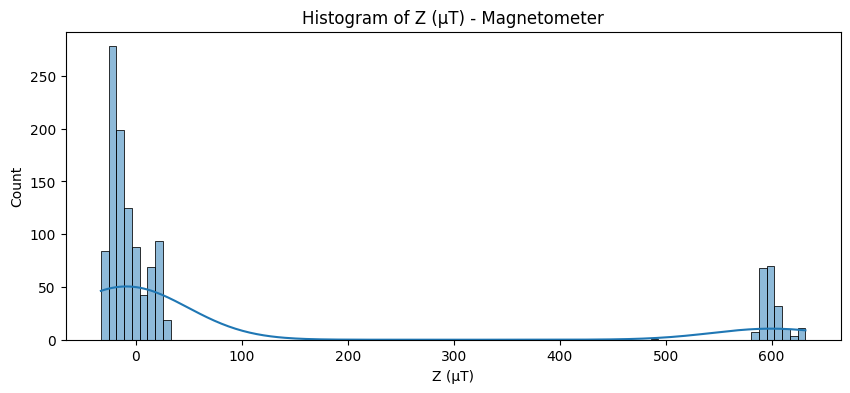

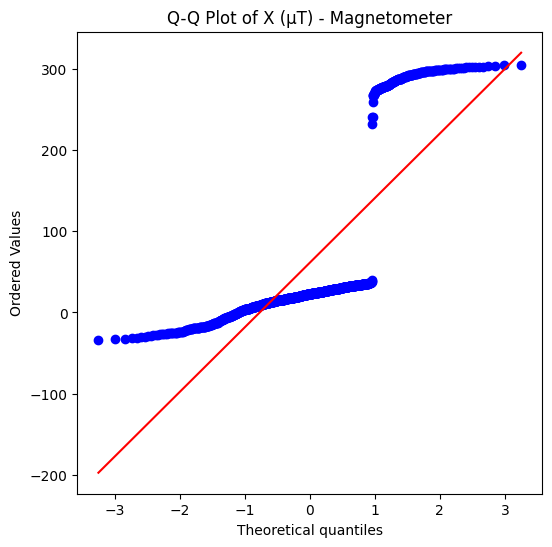

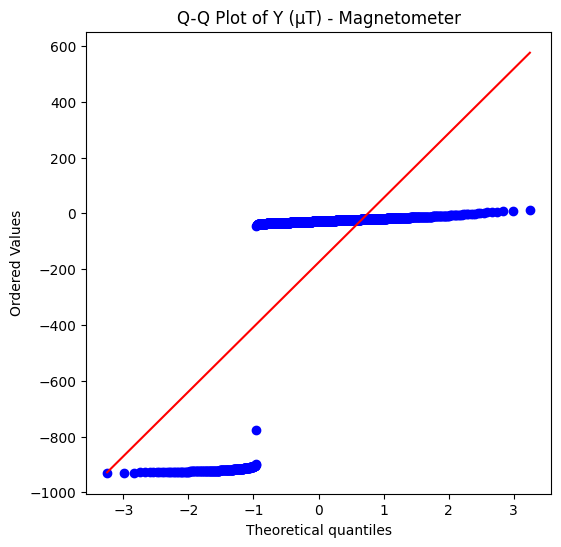

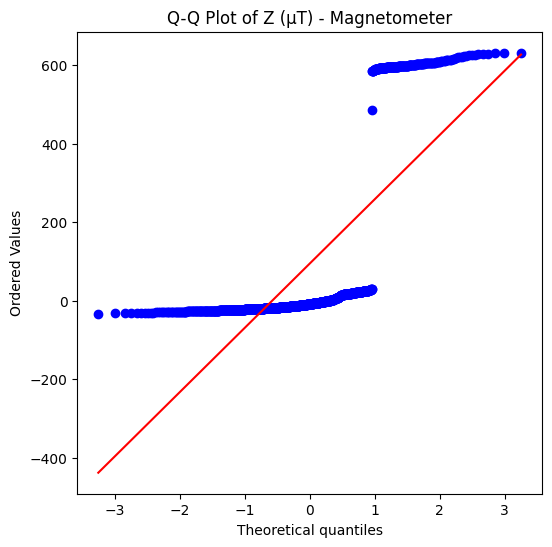

Shapiro-Wilk Test for X (µT) - Magnetometer: Statistics=5.973e-01, p=0.000e+00
X (µT) - Magnetometer does not look Gaussian (reject H0)
Shapiro-Wilk Test for Y (µT) - Magnetometer: Statistics=4.755e-01, p=0.000e+00
Y (µT) - Magnetometer does not look Gaussian (reject H0)
Shapiro-Wilk Test for Z (µT) - Magnetometer: Statistics=5.129e-01, p=0.000e+00
Z (µT) - Magnetometer does not look Gaussian (reject H0)


In [14]:

base_path = '/Users/priyank/Desktop/ML4QS-project/Wave_right_5mins'
folders = [
    'Wave_right_min_1',
    'Wave_right_min_2',
    'Wave_right_min_3',
    'Wave_right_min_4',
    'Wave_right_min_5'
]

def agg_data(base_path, folders, filename):
    data_frames = []
    for folder in folders:
        file_path = os.path.join(base_path, folder, filename)
        df = pd.read_csv(file_path)
        data_frames.append(df)
    combined_data = pd.concat(data_frames, ignore_index=True)
    return combined_data

# Load the aggregated data
accel_data = agg_data(base_path, folders, 'Accelerometer_0.25s.csv')
gyro_data = agg_data(base_path, folders, 'Gyroscope_0.25s.csv')
linear_accel_data = agg_data(base_path, folders, 'Linear Accelerometer_0.25s.csv')
magnetometer_data = agg_data(base_path, folders, 'Magnetometer_0.25s.csv')

# Check for normality using visual methods and statistical tests

# Function to plot histograms
def plot_histograms(data, cols, sensor):
    for col in cols:
        plt.figure(figsize=(10, 4))
        sns.histplot(data[col], kde=True)
        plt.title(f'Histogram of {col} - {sensor}')
        plt.show()

# Function to plot Q-Q plots
def plot_qq(data, cols, sensor):
    for col in cols:
        plt.figure(figsize=(6, 6))
        stats.probplot(data[col], dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of {col} - {sensor}')
        plt.show()

# Function to perform Shapiro-Wilk Test
def shapiro_test(data, cols, sensor):
    for col in cols:
        stat, p = stats.shapiro(data[col])
        print(f'Shapiro-Wilk Test for {col} - {sensor}: Statistics={stat:.3e}, p={p:.3e}')
        if p > 0.05:
            print(f'{col} - {sensor} looks Gaussian (fail to reject H0)')
        else:
            print(f'{col} - {sensor} does not look Gaussian (reject H0)')


# Columns to check for normality for each sensor
columns = {
    'accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'gyroscope': ['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)'],
    'linear_accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'magnetometer': ['X (µT)', 'Y (µT)', 'Z (µT)']
}

# Perform checks on accelerometer data
print("Accelerometer Data Normality Check:")
plot_histograms(accel_data, columns['accelerometer'], 'Accelerometer')
plot_qq(accel_data, columns['accelerometer'], 'Accelerometer')
shapiro_test(accel_data, columns['accelerometer'], 'Accelerometer')

# Perform checks on gyroscope data
print("\nGyroscope Data Normality Check:")
plot_histograms(gyro_data, columns['gyroscope'], 'Gyroscope')
plot_qq(gyro_data, columns['gyroscope'], 'Gyroscope')
shapiro_test(gyro_data, columns['gyroscope'], 'Gyroscope')

# Perform checks on linear accelerometer data
print("\nLinear Accelerometer Data Normality Check:")
plot_histograms(linear_accel_data, columns['linear_accelerometer'], 'Linear Accelerometer')
plot_qq(linear_accel_data, columns['linear_accelerometer'], 'Linear Accelerometer')
shapiro_test(linear_accel_data, columns['linear_accelerometer'], 'Linear Accelerometer')

# Perform checks on magnetometer data
print("\nMagnetometer Data Normality Check:")
plot_histograms(magnetometer_data, columns['magnetometer'], 'Magnetometer')
plot_qq(magnetometer_data, columns['magnetometer'], 'Magnetometer')
shapiro_test(magnetometer_data, columns['magnetometer'], 'Magnetometer')

# Outlier Checks - simple version

In [15]:
from scipy import stats

# Function to detect outliers using Z-score method
def detect_outliers_zscore(df, threshold=3):
    outliers = pd.DataFrame()
    for col in df.columns:
        if col not in ['time', 'label']:
            z_scores = np.abs(stats.zscore(df[col]))
            outliers[col] = z_scores > threshold
    return outliers

# Detect outliers for each individual file using Z-score method
for sensor_type in sensor_types:
    for i, df in enumerate(aggregated_data_dict[sensor_type]):
        outliers = detect_outliers_zscore(df)
        print(f"Outliers detected in {sensor_type} - File {i+1}:")
        print(outliers.sum())

Outliers detected in accelerometer - File 1:
X (m/s^2)    0
Y (m/s^2)    0
Z (m/s^2)    1
dtype: int64
Outliers detected in accelerometer - File 2:
X (m/s^2)    0
Y (m/s^2)    1
Z (m/s^2)    1
dtype: int64
Outliers detected in accelerometer - File 3:
X (m/s^2)    0
Y (m/s^2)    4
Z (m/s^2)    1
dtype: int64
Outliers detected in accelerometer - File 4:
X (m/s^2)    0
Y (m/s^2)    1
Z (m/s^2)    0
dtype: int64
Outliers detected in accelerometer - File 5:
X (m/s^2)    0
Y (m/s^2)    2
Z (m/s^2)    1
dtype: int64
Outliers detected in gyroscope - File 1:
X (rad/s)    4
Y (rad/s)    2
Z (rad/s)    0
dtype: int64
Outliers detected in gyroscope - File 2:
X (rad/s)    0
Y (rad/s)    3
Z (rad/s)    0
dtype: int64
Outliers detected in gyroscope - File 3:
X (rad/s)    0
Y (rad/s)    1
Z (rad/s)    0
dtype: int64
Outliers detected in gyroscope - File 4:
X (rad/s)    0
Y (rad/s)    0
Z (rad/s)    0
dtype: int64
Outliers detected in gyroscope - File 5:
X (rad/s)    4
Y (rad/s)    2
Z (rad/s)    0
dty

In [16]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(df, k=1.5):
    outliers = pd.DataFrame()
    for col in df.columns:
        if col not in ['time', 'label']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - k * IQR
            upper_bound = Q3 + k * IQR
            outliers[col] = (df[col] < lower_bound) | (df[col] > upper_bound)
    return outliers

# Detect outliers for each individual file using IQR method
for sensor_type in sensor_types:
    for i, df in enumerate(aggregated_data_dict[sensor_type]):
        outliers = detect_outliers_iqr(df)
        print(f"Outliers detected in {sensor_type} - File {i+1}:")
        print(outliers.sum())


Outliers detected in accelerometer - File 1:
X (m/s^2)     0
Y (m/s^2)    14
Z (m/s^2)     5
dtype: int64
Outliers detected in accelerometer - File 2:
X (m/s^2)     0
Y (m/s^2)    14
Z (m/s^2)     2
dtype: int64
Outliers detected in accelerometer - File 3:
X (m/s^2)     0
Y (m/s^2)    23
Z (m/s^2)     2
dtype: int64
Outliers detected in accelerometer - File 4:
X (m/s^2)    0
Y (m/s^2)    2
Z (m/s^2)    0
dtype: int64
Outliers detected in accelerometer - File 5:
X (m/s^2)     0
Y (m/s^2)    15
Z (m/s^2)     1
dtype: int64
Outliers detected in gyroscope - File 1:
X (rad/s)    12
Y (rad/s)     9
Z (rad/s)     0
dtype: int64
Outliers detected in gyroscope - File 2:
X (rad/s)    0
Y (rad/s)    4
Z (rad/s)    0
dtype: int64
Outliers detected in gyroscope - File 3:
X (rad/s)    1
Y (rad/s)    1
Z (rad/s)    0
dtype: int64
Outliers detected in gyroscope - File 4:
X (rad/s)    2
Y (rad/s)    0
Z (rad/s)    0
dtype: int64
Outliers detected in gyroscope - File 5:
X (rad/s)    4
Y (rad/s)    8
Z (

# Using Outlier functions

In [17]:
# Define Chauvenet's Criterion
def detect_outliers_chauvenet(data_table, col, C=1):
    mean = data_table[col].mean()
    std = data_table[col].std()
    N = len(data_table.index)
    criterion = 1.0 / (C * N)

    deviation = abs(data_table[col] - mean) / std

    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    for i in range(0, len(data_table.index)):
        prob.append(1.0 - 0.5 * (erf(high[i]) - erf(low[i])))
        mask.append(prob[i] < criterion)
    
    data_table[col + '_outlier'] = mask
    return data_table

# # Utility function to calculate pairwise distances
def distance(data, d_function):
    return scipy.spatial.distance.pdist(data, d_function)

# Utility function to normalize dataset
def normalize_dataset(data, cols):
    for col in cols:
        data[col] = (data[col] - data[col].mean()) / data[col].std()
    return data


# Define Local Outlier Factor (LOF)
def detect_outliers_lof(data_table, cols, d_function='euclidean', k=20):
    new_data_table = normalize_dataset(data_table.dropna(axis=0, subset=cols), cols)
    distances = pd.DataFrame(
        scipy.spatial.distance.squareform(distance(new_data_table[cols], d_function)),
        columns=new_data_table.index, index=new_data_table.index
    ).astype('float32')

    lof = LocalOutlierFactor(n_neighbors=k, metric=d_function)
    for col in cols:
        df_col = data_table[col].values.reshape(-1, 1)
        outlier_flags = lof.fit_predict(df_col)
        data_table['lof'] = outlier_flags == -1

    return data_table


In [18]:
# Load aggregated data
aggregated_data_dict = load_aggregated_data(file_paths)

# Initialize a list to store the summary results
summary_results = []

# Apply outlier detection methods
for sensor_type in sensor_types:
    for i, df in enumerate(aggregated_data_dict[sensor_type]):
        result = {'Sensor Type': sensor_type, 'File': f'{sensor_type}_file_{i+1}'}

        if sensor_type == 'accelerometer' or sensor_type == 'linear_accelerometer':
            cols = ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)']
        elif sensor_type == 'gyroscope':
            cols = ['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)']
        elif sensor_type == 'magnetometer':
            cols = ['X (µT)', 'Y (µT)', 'Z (µT)']

        # Chauvenet's Criterion
        outliers_chauvenet = detect_outliers_chauvenet(df.copy(), cols[0])
        num_outliers_chauvenet = outliers_chauvenet[cols[0] + '_outlier'].sum()
        perc_outliers_chauvenet = (num_outliers_chauvenet / len(outliers_chauvenet) * 100).round(2)
        result['Chauvenet_Num'] = num_outliers_chauvenet
        result['Chauvenet_Perc'] = perc_outliers_chauvenet

        # Local Outlier Factor (LOF)
        outliers_lof = detect_outliers_lof(df.copy(), cols)
        num_outliers_lof = outliers_lof['lof'].sum()
        perc_outliers_lof = (num_outliers_lof / len(outliers_lof) * 100).round(2)
        result['LOF_Num'] = num_outliers_lof
        result['LOF_Perc'] = perc_outliers_lof

        summary_results.append(result)

# Convert summary results to a DataFrame for a neat table
summary_df = pd.DataFrame(summary_results)

# Display the summary table
print(summary_df)

             Sensor Type                         File  Chauvenet_Num  \
0          accelerometer         accelerometer_file_1              2   
1          accelerometer         accelerometer_file_2              0   
2          accelerometer         accelerometer_file_3              3   
3          accelerometer         accelerometer_file_4              0   
4          accelerometer         accelerometer_file_5              2   
5              gyroscope             gyroscope_file_1             12   
6              gyroscope             gyroscope_file_2              9   
7              gyroscope             gyroscope_file_3             10   
8              gyroscope             gyroscope_file_4             10   
9              gyroscope             gyroscope_file_5              7   
10  linear_accelerometer  linear_accelerometer_file_1              3   
11  linear_accelerometer  linear_accelerometer_file_2              1   
12  linear_accelerometer  linear_accelerometer_file_3           

# Imputation techniques